In this file, i explore separate recommendation systems and turn them into feature generators for the neural net, then we train the neural net, final version of the system in a separate file

In [96]:
import pandas as pd
import numpy as np
import random
import os
import csv
from IPython.display import display, HTML
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder


import datetime

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import wandb
import pickle
from keras.models import load_model

from wandb.keras import WandbCallback
from tensorflow.keras import backend as K

display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
movie_data = pd.read_csv('data/film_data/prepared_film_data.csv')

In [3]:
#my simple popularity based score takes into account avg. rating, vote count and release year (favoring more recent films)

def calculate_popularity_score(df, alpha = 0.8, beta=1, gamma=0.002): #alpha, beta and gamma ar weights for votecount, avg.rating, release year
    df = df.copy()
    df['norm_numVotes'] = df['numVotes'] / df['numVotes'].max()
    df['norm_averageRating'] = df['averageRating'] / df['averageRating'].max()
    df['norm_startYear'] = (df['startYear'] - df['startYear'].min()) / (df['startYear'].max() - df['startYear'].min())
    df['popularity_score'] = alpha *df['norm_numVotes'] + beta * df['norm_averageRating'] + gamma * df['norm_startYear']
    df = df.drop(columns=['norm_numVotes', 'norm_averageRating', 'norm_startYear'])
    
    return df

In [4]:
movie_data_with_popularity = calculate_popularity_score(movie_data)
movie_data_with_popularity = movie_data_with_popularity.sort_values('popularity_score', ascending=False)

In [5]:
movie_data_with_popularity.head(10)

,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,primaryName,Action,Adult,...,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,\N,popularity_score
22163,tt0111161,The Shawshank Redemption,0,1994.0,142.0,9.3,2733330.0,Frank Darabont,0,0,...,0,0,0,0,0,0,0,0,0,1.731550
183357,tt0468569,The Dark Knight,0,2008.0,152.0,9.0,2706445.0,Christopher Nolan,1,0,...,0,0,0,0,0,0,0,0,0,1.693899
206172,tt1375666,Inception,0,2010.0,148.0,8.8,2402346.0,Christopher Nolan,1,0,...,0,1,0,0,0,0,0,0,0,1.584925
23700,tt0137523,Fight Club,0,1999.0,139.0,8.8,2176102.0,David Fincher,0,0,...,0,0,0,0,0,0,0,0,0,1.518537
153386,tt0110912,Pulp Fiction,0,1994.0,154.0,8.9,2100399.0,Quentin Tarantino,0,0,...,0,0,0,0,0,0,0,0,0,1.506302
120287,tt0109830,Forrest Gump,0,1994.0,142.0,8.8,2126909.0,Robert Zemeckis,0,0,...,1,0,0,0,0,0,0,0,0,1.504061
152940,tt0068646,The Godfather,0,1972.0,175.0,9.2,1900604.0,Francis Ford Coppola,0,0,...,0,0,0,0,0,0,0,0,0,1.477484
180300,tt0167260,The Lord of the Rings: The Return of the King,0,2003.0,201.0,9.0,1880210.0,Peter Jackson,1,0,...,0,0,0,0,0,0,0,0,0,1.451996
270191,tt0133093,The Matrix,0,1999.0,136.0,8.7,1949993.0,Lana Wachowski,1,0,...,0,1,0,0,0,0,0,0,0,1.442358
180224,tt0120737,The Lord of the Rings: The Fellowship of the Ring,0,2001.0,178.0,8.8,1909123.0,Peter Jackson,1,0,...,0,0,0,0,0,0,0,0,0,1.440427


Now that we have a function that calculates the popularity, lets build a function that returns 5 movies for someone that doesnt know anything, the function will allow to pick the genre and return some very high rated movies based on the popularity score at random (so the recommended movies arent the same every time.

In [6]:
def get_pop_movies_with_random(df, num_movies=5, top_percent = 0.01, min_votes= 10000, random_seed=None, genre=None):
    
    if random_seed is not None:
        random.seed(random_seed)
    df = df[df['numVotes'] >= min_votes]
    
    if genre is not None:
        df = df[df[genre] == 1]
        
    top_n = int(df.shape[0] * top_percent)
    top_movies = df.head(top_n)
    
    num_movies = min(num_movies, top_movies.shape[0])
    selected_movies = top_movies.sample(num_movies, replace=False)
    
    
    columns=['primaryTitle', 'startYear', 'averageRating', 'numVotes']
    selected_movies = selected_movies[columns]
    
    return selected_movies

In [7]:
print(get_pop_movies_with_random(movie_data_with_popularity, num_movies=5, min_votes= 1000, random_seed=None, genre='Drama'))

                              primaryTitle  startYear  averageRating  \
120513                             Titanic     1997.0            7.9   
194112                             Dunkirk     2017.0            7.8   
48515   National Theatre Live: Prima Facie     2022.0            9.3   
211281                               Joker     2019.0            8.4   
120024                     Cinema Paradiso     1988.0            8.5   

         numVotes  
120513  1215194.0  
194112   678825.0  
48515      1211.0  
211281  1343504.0  
120024   267248.0  


Incorporating a **content-based recommendation** system within a movie recommendation engine is key for delivering personalized suggestions tailored to users' unique preferences. This approach complements broader methods like popularity-based and collaborative filtering, ensuring diverse recommendations that reflect individual tastes. By considering specific movie features, content-based recommendations help users discover new, lesser-known titles that align with their interests, enhancing their overall movie-watching experience.

In [8]:
user_watchlists = pd.read_csv('data/user_ratings_data/user_watchlists.csv')
user_watchlists.drop(columns=['Unnamed: 0'], inplace=True)
user_watchlists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470199 entries, 0 to 2470198
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  object
 1   imdb_id  object
 2   rating   int64 
dtypes: int64(1), object(2)
memory usage: 56.5+ MB


In [9]:
def create_user_profiles(movie_data, user_watchlists):
    genre_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
                     'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
                     'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
    
    user_movie_data = user_watchlists.merge(movie_data, left_on='imdb_id', right_on='tconst', how='inner') #merge both df's
    
    user_movie_data['penalty_factor'] = user_movie_data['rating']/ 10
    
    user_movie_data[genre_columns] = user_movie_data[genre_columns].multiply(user_movie_data['rating'] * user_movie_data['penalty_factor'], axis="index")
    
    user_movie_data['weighted_genres'] = user_movie_data[genre_columns].apply(lambda row: np.array(row), axis=1)
    user_profiles = user_movie_data.groupby('user_id')['weighted_genres'].apply(lambda x: np.mean(np.vstack(x), axis=0))
    
    return user_profiles

In [10]:
def recommend_movies_based_on_genre(movie_data, user_watchlists, new_user_watchlist, num_pool=50, num_recommendations=10, alpha=0.7):
    
    
    movie_data = movie_data[movie_data['numVotes'] >= 5000]
    movie_data_with_popularity = calculate_popularity_score(movie_data)
    
    combined_watchlist = pd.concat([user_watchlists, new_user_watchlist])
    user_id = new_user_watchlist.iloc[1, 0]
    user_profiles = create_user_profiles(movie_data_with_popularity, combined_watchlist)
    
    user_profile = user_profiles.loc[user_id]
    
    genre_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
                     'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
                     'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
    
    
    
    genre_matrix  = movie_data_with_popularity[genre_columns].values
    similarity_scores = cosine_similarity([user_profile], genre_matrix)
    
    popularity_scores = movie_data_with_popularity['popularity_score']
    
    weighted_similarity_scores = alpha * similarity_scores + (1-alpha) * popularity_scores.values.reshape(1, -1)
    
    sorted_movie_indices = np.argsort(weighted_similarity_scores[0])[::-1]
    user_seen_movies = set(new_user_watchlist['imdb_id'])
    
    recommended_movie_ids  = []
    for movie_idx in sorted_movie_indices:
        movie_id = movie_data_with_popularity.iloc[movie_idx]['tconst']
        if movie_id not in user_seen_movies:
            recommended_movie_ids.append(movie_id)
        if len(recommended_movie_ids) >= num_pool:
            break;
            
            
    final_recomendations = random.sample(recommended_movie_ids, num_recommendations)
    columns=['primaryTitle', 'startYear', 'averageRating', 'numVotes']
    
    return movie_data_with_popularity.loc[movie_data_with_popularity['tconst'].isin(final_recomendations)][columns]

In [11]:
manto_watchlistas = pd.read_csv('data/user_ratings_data/test_ratings.csv')
karolinos_watchlistas = pd.read_csv('data/user_ratings_data/test_ratings2.csv')

In [12]:
print(recommend_movies_based_on_genre(movie_data, user_watchlists, manto_watchlistas, num_recommendations=10))

                          primaryTitle  startYear  averageRating  numVotes
179699   Ben-Hur: A Tale of the Christ     1925.0            7.8    7766.0
179952             The Hidden Fortress     1958.0            8.1   40306.0
180336  Crouching Tiger, Hidden Dragon     2000.0            7.9  275029.0
180500                            Hero     2002.0            7.9  184110.0
215887             Steamboat Bill, Jr.     1928.0            7.8   15305.0
215915                    Mother India     1957.0            7.8    9572.0
215984                       Mr. India     1987.0            7.7   15997.0
216347               Riders of Justice     2020.0            7.5   54384.0
216561       Kisi Ka Bhai Kisi Ki Jaan     2023.0            7.3   33537.0
216636                   Minnal Murali     2021.0            7.8   30907.0


In [13]:
print(recommend_movies_based_on_genre(movie_data, user_watchlists, karolinos_watchlistas, num_recommendations=10))

                                     primaryTitle  startYear  averageRating  \
35621                         There Will Be Blood     2007.0            8.2   
38666                           The Kashmir Files     2022.0            8.7   
143372                                The Witness     1969.0            8.7   
144065                         Dead Poets Society     1989.0            8.1   
144609                            The Truman Show     1998.0            8.2   
146223                        Lost in Translation     2003.0            7.7   
146859                       Little Miss Sunshine     2006.0            7.8   
180301      The Lord of the Rings: The Two Towers     2002.0            8.8   
180747                               The Revenant     2015.0            8.0   
213125  Three Billboards Outside Ebbing, Missouri     2017.0            8.1   

         numVotes  
35621    599947.0  
38666    564031.0  
143372     7320.0  
144065   507004.0  
144609  1111443.0  
146223   4

In [14]:
user_watchlists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470199 entries, 0 to 2470198
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  object
 1   imdb_id  object
 2   rating   int64 
dtypes: int64(1), object(2)
memory usage: 56.5+ MB


In [15]:
# this implementation considers 1 movie and its similaity to others based on user ratings

def create_user_movie_matrix(ratings_data, min_votes=50, min_ratings=10):
    
    popular_movies = ratings_data.groupby('imdb_id').filter(lambda x: len(x) >= min_votes) #too many movies, need to make this smaller

   
    active_users = popular_movies.groupby('user_id').filter(lambda x: len(x) >= min_ratings)  # filter users with few ratings
    
    return active_users.pivot_table(index='user_id', columns='imdb_id', values='rating').fillna(0).astype('uint8') #pivot to get a matrix, change type from float64 to int8 to save space and time
    
    
    


def compute_movie_similarity(user_movie_matrix):
    user_movie_matrix_filled = user_movie_matrix.fillna(0)   # cant be empty to calculate cosine similary 
    return cosine_similarity(user_movie_matrix_filled.T)


def get_top_similar_movies(movie_id, user_movie_matrix, similarity_matrix, n=10):
    movie_idx = user_movie_matrix.columns.get_loc(movie_id)
    similar_movie_indices = np.argsort(similarity_matrix[movie_idx])[::-1][1:n+1]
    similar_movie_ids = [user_movie_matrix.columns[i] for i in similar_movie_indices]
    return similar_movie_ids

In [16]:
test = create_user_movie_matrix(user_watchlists)
test2 = compute_movie_similarity(test)
test3 = get_top_similar_movies('tt1191111', test, test2)
recommended_movies = movie_data[movie_data['tconst'].isin(test3)]
recommended_movies

,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,primaryName,Action,Adult,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,\N
47587,tt1937390,Nymphomaniac: Vol. I,0,2013.0,117.0,6.9,127211.0,Lars von Trier,0,0,...,0,0,0,0,0,0,0,0,0,0
50069,tt2382009,Nymphomaniac: Vol. II,0,2013.0,124.0,6.6,94923.0,Lars von Trier,0,0,...,0,0,0,0,0,0,0,0,0,0
125682,tt3774694,Love,0,2015.0,135.0,6.1,61999.0,Gaspar Noé,0,0,...,0,1,0,0,0,0,0,0,0,0
157821,tt0290673,Irreversible,0,2002.0,97.0,7.3,140084.0,Gaspar Noé,0,0,...,0,0,0,0,0,0,0,0,0,0
183810,tt1588170,I Saw the Devil,0,2010.0,144.0,7.8,136271.0,Jee-woon Kim,1,0,...,0,0,0,0,0,0,0,0,0,0
193670,tt1527186,Melancholia,0,2011.0,135.0,7.1,187541.0,Lars von Trier,0,0,...,0,0,1,0,0,0,0,0,0,0
201532,tt10944760,Titane,0,2021.0,108.0,6.5,49580.0,Julia Ducournau,0,0,...,0,0,1,0,0,0,0,0,0,0
246425,tt0870984,Antichrist,0,2009.0,108.0,6.5,130495.0,Lars von Trier,0,0,...,0,0,0,0,0,0,1,0,0,0
248489,tt1974419,The Neon Demon,0,2016.0,117.0,6.1,99262.0,Nicolas Winding Refn,0,0,...,0,0,0,0,0,0,1,0,0,0
264649,tt8359848,Climax,0,2018.0,97.0,6.9,72846.0,Gaspar Noé,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# now we have a function that recommends similar movies, based on user preferences, lets adjust it so it accept a whole user ratings list
def recommend_movies(user_ratings_df, user_watchlists, movie_data, min_votes=10, num_rec=10):
    
    user_movie_matrix = create_user_movie_matrix(user_watchlists, min_votes)
    similarity_matrix = compute_movie_similarity(user_movie_matrix)
    watched_movies = set(user_ratings_df['imdb_id'])
    
    total_scores = defaultdict(float)
    
    for _, row in user_ratings_df.iterrows():
        movie_id = row['imdb_id']
        rating = row['rating']
        
        if movie_id not in user_movie_matrix.columns:
            continue
        
        similar_movies = get_top_similar_movies(movie_id, user_movie_matrix, similarity_matrix, num_rec)
        
        for similar_movie in similar_movies:
            if similar_movie in watched_movies:
                continue
            total_scores[similar_movie] += similarity_matrix[user_movie_matrix.columns.get_loc(movie_id), user_movie_matrix.columns.get_loc(similar_movie)] * rating
    
    
    recommended_movies = sorted(total_scores.items(), key=lambda x: x[1], reverse=True)[:num_rec]
    recommended_movie_ids = [movie[0] for movie in recommended_movies]
    
    return movie_data[movie_data['tconst'].isin(recommended_movie_ids)]

In [18]:
new_user_ratings = pd.read_csv('data/user_ratings_data/test_ratings.csv')
recommended_movies = recommend_movies(new_user_ratings, user_watchlists, movie_data)

In [19]:
#system seems to be suggesting prety good choices, because it actually suggested some movies I saw and forgot to rate on IMDb
recommended_movies

,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,primaryName,Action,Adult,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,\N
130318,tt9784798,Judas and the Black Messiah,0,2021.0,126.0,7.4,84890.0,Shaka King,0,0,...,0,0,0,0,0,0,0,0,0,0
133944,tt0116282,Fargo,0,1996.0,98.0,8.1,690516.0,Joel Coen,0,0,...,0,0,0,0,0,0,1,0,0,0
204654,tt0119654,Men in Black,0,1997.0,98.0,7.3,582107.0,Barry Sonnenfeld,1,0,...,0,0,0,0,0,0,0,0,0,0
205364,tt6320628,Spider-Man: Far from Home,0,2019.0,129.0,7.4,511816.0,Jon Watts,1,0,...,0,0,0,0,0,0,0,0,0,0
206032,tt0090605,Aliens,0,1986.0,137.0,8.4,730119.0,James Cameron,1,0,...,0,0,1,0,0,0,0,0,0,0
231312,tt0117060,Mission: Impossible,0,1996.0,110.0,7.1,437020.0,Brian De Palma,1,0,...,0,0,0,0,0,0,1,0,0,0
241281,tt0478970,Ant-Man,0,2015.0,117.0,7.3,688979.0,Peyton Reed,1,0,...,0,0,1,0,0,0,0,0,0,0
244920,tt5363618,Sound of Metal,0,2019.0,120.0,7.7,135894.0,Darius Marder,0,0,...,0,0,0,0,0,0,0,0,0,0
269650,tt4160708,Don't Breathe,0,2016.0,88.0,7.1,284280.0,Fede Alvarez,0,0,...,0,0,0,0,0,0,1,0,0,0
270146,tt0103064,Terminator 2: Judgment Day,0,1991.0,137.0,8.6,1119034.0,James Cameron,1,0,...,0,0,1,0,0,0,0,0,0,0


In [20]:
#these functions will calculate similarity between users and assign each user-movie pair a ratings based on top 10 most similar users. This rating can be used as a feature for nn training.

def compute_user_similarity(user_movie_matrix):
    return cosine_similarity(user_movie_matrix)

def get_top_similar_users(user_id, user_movie_matrix, similarity_matrix, n=10):
    user_idx = user_movie_matrix.index.get_loc(user_id)
    similar_user_indices = np.argsort(similarity_matrix[user_idx])[::-1][1:n+1]
    similar_user_ids = [user_movie_matrix.index[i] for i in similar_user_indices]
    return similar_user_ids

def generate_user_based_scores(user_id, user_movie_matrix, similarity_matrix, n=10):
    similar_users = get_top_similar_users(user_id, user_movie_matrix, similarity_matrix, n)
    scores = user_movie_matrix.loc[similar_users].mean() #could make this better
    return scores

def add_collab_user_filter_scores(user_watchlists, movie_data_with_popularity):
    user_movie_matrix = create_user_movie_matrix(user_watchlists)
    similarity_matrix = compute_user_similarity(user_movie_matrix)
    data = pd.merge(user_watchlists, movie_data_with_popularity, left_on='imdb_id', right_on='tconst')
    
    with open('collab_user_filter_scores.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['user_id', 'imdb_id', 'collab_user_filter_score']) 

        for user_id in user_movie_matrix.index:
            print(user_id)
            user_scores = generate_user_based_scores(user_id, user_movie_matrix, similarity_matrix)

            for movie_id, score in user_scores.iteritems():
                writer.writerow([user_id, movie_id, score])

    # read after saving row by row
    collab_user_filter_scores_df = pd.read_csv('collab_user_filter_scores.csv')

    data = pd.merge(data, collab_user_filter_scores_df, on=['user_id', 'imdb_id'], how='left')
    
    return data


#sadly cant run this to calculate similarity for all user-movies

In [21]:
# calculate similarity scores and add them to training data
user_movie_pop_user = add_collab_user_filter_scores(user_watchlists, movie_data_with_popularity)

ur0001220
ur0002746
ur0011762
ur0019730
ur0033913
ur0035229
ur0041696
ur0041958
ur0064493
ur0082768
ur0090373
ur0096314
ur0100872
ur0101706
ur0102816
ur0104014
ur0109692


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur0116020
ur0121776
ur0121799
ur0127279
ur0134919
ur0137908
ur0139451
ur0157498
ur0163443
ur0179443
ur0215141
ur0222418
ur0226855
ur0234039
ur0234628


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur0234740
ur0265899
ur0277234
ur0278021
ur0281280
ur0281853
ur0290901
ur0307374
ur0310469
ur0311809
ur0312444
ur0327799
ur0334570
ur0342623
ur0344145
ur0351766
ur0355122
ur0359842
ur0361658
ur0366419
ur0375636
ur0376597
ur0382023
ur0384452
ur0384847
ur0391152
ur0394025
ur0408027
ur0417992
ur0426613


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur0434661
ur0437174
ur0442119
ur0449021
ur0450172
ur0453068
ur0464186
ur0480393
ur0482513
ur0489763
ur0491610
ur0499651
ur0508954
ur0509769
ur0510266
ur0531455


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur0543054
ur0547401
ur0574035
ur0581842
ur0583640
ur0592531
ur0605857
ur0609951
ur0610628
ur0618701
ur0629528
ur0636545
ur0649363
ur0650255
ur0657462


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur0708661
ur0715971
ur0728175
ur0730831
ur0731006
ur0738625
ur0760186
ur0768737
ur0783721
ur0812029
ur0818185
ur0826090
ur0842723
ur0855231
ur0872211


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur0882646
ur0908789
ur0914942
ur0914980
ur0915482
ur0931671
ur0937743
ur0939196
ur0968789
ur0972645
ur0984863
ur0989940
ur100116496
ur100147162
ur10048899
ur100620929


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur1010941
ur10122044
ur10154899
ur10158229
ur1016453
ur1017834
ur102146571
ur102184407
ur102221188
ur102222939
ur102266923
ur1022917
ur102454372
ur1025181
ur102605581
ur1027255


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur102865009
ur10298283
ur10326951
ur10327852
ur10334028
ur103663848
ur10384462
ur10398346
ur104180774
ur104563194
ur104603847
ur1046557
ur104763420
ur104889023
ur105044330
ur105082429


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur1052099
ur1053129
ur10543786
ur105484415
ur105553029
ur105556039
ur105617842
ur105769172
ur105954145
ur106007927
ur1061970
ur106224983
ur106279729
ur106641918
ur10667275
ur106844093


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur1069062
ur107065132
ur107152571
ur107273206
ur10742541
ur107448545
ur1075931
ur107612409
ur108118797
ur108361571
ur108662740
ur108874341
ur1090944
ur109374849
ur109780620
ur109868736


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur11001042
ur110212703
ur11040152
ur11059167
ur110759166
ur111092901
ur111476141
ur11148131
ur1115221
ur111568373
ur111579859
ur1116241
ur11167152
ur112067187
ur11215533


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur112234773
ur11228318
ur11255560
ur11282886
ur113506463
ur113693169
ur113728088
ur11387233
ur11415716
ur11423174
ur1142410
ur114450253
ur114491145
ur11452429
ur114665947


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur114667321
ur114797517
ur1148847
ur114907932
ur115595273
ur115649160
ur11565674
ur11590833
ur115921785
ur116279971
ur116311378
ur11701403
ur11724809
ur1173088


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur117354284
ur117424303
ur11750202
ur117710760
ur118288211
ur11839633
ur118665987
ur118679533
ur118818818
ur119082541
ur119265515
ur11934404
ur1195884
ur11985270
ur12011873
ur120205176
ur1203594
ur120413622
ur120431365
ur120447312
ur12048299
ur12084573
ur1208984
ur120966602
ur12100977
ur1210420
ur121145920
ur121409096
ur1214734
ur12164854


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur1218856
ur1219578
ur122270985
ur12230254
ur122400466
ur12249695
ur122647227
ur123203865
ur12327230
ur1234929
ur1235078
ur12449122
ur124499942
ur124569626
ur1246303
ur1248617


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur124950434
ur125187549
ur1252120
ur1257208
ur125953851
ur12596887
ur12643360
ur12645538
ur1265906
ur12666537
ur12680645
ur127045296
ur127050058
ur12720448
ur127683169
ur12771356


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur128231534
ur12844960
ur128851908
ur12906670
ur129208002
ur1296280
ur130122628
ur13017201
ur130268359
ur13066302
ur13074316
ur131092653
ur131499933
ur131783850
ur13178622
ur1318549
ur132395489
ur13240360
ur13288300
ur133058434
ur133472560
ur1339231
ur1339930
ur13401764
ur1343496
ur134783880
ur13496665
ur1350313
ur135273424
ur13549369


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur1355003
ur13566917
ur13599575
ur13630333
ur136385244
ur13724283
ur13741111
ur1376555
ur13860020
ur13887584
ur13891183
ur1390493
ur139178891
ur13977076
ur1399158
ur13995491


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur14043003
ur1406466
ur140941989
ur14121727
ur14150913
ur14294603
ur14295241
ur14299499
ur14311200
ur14327965
ur14407359
ur144096861
ur1444027
ur1448185
ur145025145
ur145118680
ur145196473
ur14551063
ur1457119
ur14612223
ur146245308
ur14692191
ur14755689
ur14795108
ur14822166
ur1500205
ur1501216
ur15105347
ur15148330


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur15211435
ur15246875
ur15298231
ur15311310
ur15326312
ur15327507
ur153662402
ur15375264
ur15445210
ur1559834
ur15704995
ur15711750
ur1577474
ur15780544
ur15795433
ur1581184


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur1584405
ur1587884
ur15891857
ur15896852
ur15899300
ur1590118
ur15932214
ur159666074
ur1596808
ur15977902
ur1601212
ur1609501
ur1616919
ur1617546
ur1622466


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur16237357
ur16488747
ur16588387
ur16625740
ur16749093
ur16826873
ur1688846
ur16911899
ur1697212
ur16998042
ur17029428
ur17067687
ur17069294
ur1710534
ur1713651
ur1731701


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur17402378
ur17402599
ur17406914
ur1744675
ur17471213
ur17472655
ur1750882
ur17513007
ur17527919
ur17582233
ur17590531
ur17615485
ur17646017
ur17651340
ur17687207
ur17718651


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur1773017
ur1773414
ur17816293
ur17822437
ur17825945
ur1784557
ur17879959
ur18000748
ur1803589
ur18044142
ur18074616
ur18268773
ur18279193
ur18364527
ur18374284
ur18374320
ur18408040


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur18499083
ur18532003
ur18622219
ur18624974
ur18634170
ur1866601
ur18723110
ur1878251
ur18874471
ur1890722
ur18982588
ur1899036
ur19009969
ur19117722
ur19277627
ur19392148
ur19404364
ur19484559
ur19510928
ur1951246
ur19536006
ur19556601
ur1955998
ur19589623
ur19611175
ur19648580
ur19703815
ur19752191
ur1977084
ur1980092


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur1982609
ur19831446
ur19860411
ur1994077
ur19968579
ur19998007
ur20010568
ur2004984
ur20059442
ur20088107
ur20126823
ur20190389
ur2020154
ur20215511
ur2023933
ur20243955


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur20275121
ur20315186
ur20327151
ur20375346
ur20440192
ur20454428
ur20495871
ur20509588
ur20531137
ur20568198
ur20654705
ur2067905
ur20682472
ur20682974
ur20684087
ur20745279
ur2079400
ur20860432
ur20871749
ur20905375
ur20916867
ur2093818
ur2095936
ur20961309
ur20962118
ur20988789
ur21054934
ur21101534
ur21108884


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur21182619
ur2121650
ur21241039
ur21242033
ur21249326
ur2159981
ur21630011
ur21831381
ur21833437
ur21853024
ur21853963
ur21869650
ur21881328
ur2194868
ur21991915
ur22003481


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur22008076
ur22066568
ur22122641
ur22131361
ur22164449
ur22171966
ur22201610
ur22223892
ur22283965
ur22301934
ur2235654
ur2248099
ur22487163
ur22507470
ur22513682
ur22529727


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur2256253
ur2257122
ur22618683
ur22630675
ur22640195
ur22643593
ur22668817
ur22751513
ur22761455
ur22779251
ur22836725
ur22852340
ur22858299
ur22859130
ur22864666
ur2286500


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur22878174
ur22893623
ur2293784
ur2295338
ur22956348
ur22996114
ur23003350
ur23018536
ur23082930
ur23096180
ur23138767
ur23172000
ur23172671
ur23188638
ur23222655


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur23240045
ur2326544
ur23293799
ur23318905
ur23322740
ur23334796
ur23351007
ur2335852
ur23390845
ur23426612
ur23483288
ur23484859
ur23505865
ur23537468
ur2354731
ur23566468


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur23581966
ur23594963
ur23604006
ur23610960
ur23615179
ur23654883
ur2366174
ur23675942
ur23682131
ur23729172
ur23740799
ur23749646
ur2375356
ur23757827
ur2376422
ur2377279


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur23787962
ur23830022
ur23831033
ur23843983
ur2385191
ur2388570
ur23909420
ur23916871
ur23932157
ur23949705
ur23990121
ur24005016
ur24010163
ur2403537
ur24035524


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur24043409
ur24051747
ur2409664
ur2415124
ur24176568
ur24181359
ur2419668
ur24204899
ur24207434
ur24230755
ur24340247
ur24365278
ur24373984
ur24420950
ur24476688
ur2449095
ur24536951
ur2457088
ur24593235
ur24604247
ur24622549
ur24623283
ur2463817
ur24654656
ur24674937
ur24700341
ur24709314
ur24733533
ur24747273


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur24750010
ur24770944
ur24880647
ur24884343
ur24894177
ur24951456
ur25004586
ur25157350
ur25164572
ur25182004
ur2521222
ur25226117
ur25312605
ur2531610
ur25364506
ur25414655


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur2542703
ur25497641
ur25550262
ur25591817
ur25664248
ur25775215
ur25790270
ur25837689
ur25851619
ur2586978
ur25898729
ur2600145
ur26030604
ur26083589
ur26129792
ur2613818
ur26163020
ur2619078
ur26226712
ur26266323
ur26267201
ur26285744
ur2637155
ur2650604
ur26508046
ur2655139
ur26591649
ur26680166
ur2670273
ur26779379


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur26823808
ur2691100
ur2691652
ur26932797
ur26966190
ur27018907
ur2708165
ur27115898
ur27159660
ur27218700
ur2735453
ur27361979
ur2737479
ur27377411
ur27436020
ur2747461


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur27557228
ur27588885
ur27637510
ur2767381
ur27717789
ur27745349
ur27774704
ur27818897
ur27840894
ur2790158
ur27921253
ur28009688
ur2812446
ur28159509
ur28221379
ur28237482


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur28259137
ur28425280
ur28495330
ur28510263
ur2866837
ur28679870
ur28701258
ur28714483
ur28828292
ur2892021
ur28935107
ur2898980
ur2902122
ur2904081
ur2904674
ur29073007
ur29078719


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur29138457
ur2918635
ur29207347
ur29222194
ur2929860
ur29348863
ur29377569
ur29385135
ur29399766
ur29500838
ur2955724
ur29565770
ur29571289
ur29592278
ur29615467
ur29669464
ur29699367
ur29707948
ur2976262
ur30091810
ur30136144
ur30245478
ur30329898
ur30378682
ur30431619
ur3056473
ur30637326
ur30699123
ur3071695
ur3079504
ur30872044


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur30886579
ur30888832
ur3109237
ur3109921
ur31117020
ur3112639
ur31221670
ur31228772
ur31261952
ur3130665
ur31328960
ur3144117
ur31464766
ur31509300
ur3153189
ur31638149


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur31646645
ur3167410
ur31710755
ur3173363
ur3173493
ur3174947
ur31843754
ur3192976
ur32106619
ur32123286
ur3212364
ur3223254
ur32235533
ur32249954
ur3225430


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur32512011
ur32544613
ur3257585
ur32603220
ur3270789
ur32724383
ur32764997
ur3289328
ur32941074
ur33076543
ur33095909
ur3310187
ur33162918
ur3321740
ur33374263


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur33398577
ur33465207
ur33572331
ur3387663
ur33907744
ur3397538
ur34027110
ur34068231
ur34242996
ur34270927
ur34290913
ur34307814
ur3436679
ur34435688
ur3443744
ur34627686


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur34632605
ur34647768
ur34664440
ur34738421
ur34740948
ur34774928
ur34814382
ur34845698
ur34857808
ur34893557
ur34967775
ur35103889
ur35149731
ur35158467
ur35295243


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur35307871
ur35349433
ur35359466
ur3536978
ur35376689
ur35401964
ur35510778
ur35513146
ur35544190
ur35547309
ur35642927
ur3565400
ur35683824
ur35717158
ur35792474
ur35793976


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur35799870
ur3580907
ur35860616
ur35883057
ur3588397
ur35939444
ur35965350
ur35981906
ur36071542
ur3608743
ur3610419
ur3619160
ur36199884
ur36246296
ur3625584


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur36357573
ur36409180
ur36422659
ur36527471
ur3661606
ur36657881
ur36673610
ur3670492
ur36718608
ur36777513
ur36863705
ur36885175
ur36922988
ur3694796
ur3708420


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur37149208
ur37268498
ur37280403
ur3728510
ur37365377
ur3748972
ur37544303
ur37568851
ur37599117
ur3770129
ur37727343
ur37791036
ur37795971
ur37874877
ur37913663
ur3798706
ur38011481
ur3805352
ur38070473
ur38077550
ur3824745
ur3829133
ur38365655
ur3836774
ur38380213
ur3845724
ur3847467
ur38614372
ur3869264
ur3900909


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur39025333
ur3902771
ur39179311
ur39229604
ur3924830
ur39322316
ur39472049
ur3947986
ur39517558
ur39545824
ur3955578
ur39620085
ur3963754
ur3967726
ur39693839


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur3972182
ur39725388
ur39953227
ur40116064
ur40127150
ur40191153
ur40204638
ur40243436
ur4025773
ur4031417
ur40349280
ur4034943
ur40547513
ur4064696
ur40664607
ur4080067


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur41001777
ur41031967
ur4106628
ur4108130
ur41107215
ur41184683
ur41190689
ur41195938
ur4136571
ur41446733
ur4145136
ur41482037
ur41485753
ur41545937
ur41574791
ur4161069


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur41717426
ur41955249
ur42019830
ur42233352
ur42278688
ur4234119
ur4234648
ur42351091
ur4238363
ur4248714
ur42508869
ur42936359
ur4294858
ur43115153
ur43219975
ur43253475
ur4328588


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur43344880
ur43363139
ur43437598
ur43483305
ur43733933
ur43892963
ur43914432
ur43980738
ur4405474
ur4409266
ur44112735
ur44289859
ur44366382
ur44482045
ur44513981


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur44537684
ur44546721
ur4454789
ur44584461
ur44588015
ur4465293
ur44721165
ur44841124
ur4491531
ur44965663
ur45060413
ur4506876
ur45246829
ur45303257
ur45390749
ur45507551
ur4555280
ur45571519
ur45587294
ur45657926
ur45741325
ur45779447
ur45812214
ur4593705
ur4602452
ur46087760
ur4609782
ur4610211
ur46169466
ur46204888


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur46420090
ur46581731
ur46647047
ur46781604
ur46804064
ur46911997
ur46915265
ur47006221
ur47100167
ur47156081
ur47204983
ur47231689
ur47239035
ur47246436
ur47315748


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur47458493
ur47773744
ur48030148
ur48192431
ur48279852
ur4841956
ur48503549
ur48552332
ur48556426
ur48675674
ur4894536
ur48961864
ur48973907
ur49251597
ur49313789


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur4939636
ur49400835
ur49413379
ur4944007
ur4955982
ur49561414
ur49723809
ur49809624
ur4989916
ur49928194
ur49931492
ur50009926
ur50142552
ur5031062
ur50320664
ur50361292
ur50423587


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur50489624
ur50524798
ur50600143
ur50642802
ur50681813
ur5080794
ur50862542
ur50947585
ur50950195
ur51094543
ur51104328
ur51330777
ur5151340
ur5159699
ur51802347
ur5204275
ur52112075
ur5218976
ur5223663
ur5228267
ur5232724
ur52343944
ur52446284
ur52569309
ur52600820
ur5261700
ur5284108
ur52871493
ur5312246
ur53150945
ur53308260


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur53318196
ur53374879
ur53403649
ur5347756
ur53620903
ur53645293
ur53660798
ur5368428
ur53693454
ur53713622
ur53732923
ur53742734
ur53757302
ur5385644
ur53918492
ur53968709


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur54176053
ur5424352
ur54566421
ur54621033
ur54693014
ur54724846
ur54781437
ur5489888
ur54906652
ur54952250
ur54999105
ur55009047
ur55249699
ur5537539
ur55385067
ur55418749
ur55457799


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur55517503
ur5555913
ur55597043
ur55640799
ur55752007
ur55788478
ur55828906
ur55912145
ur55939332
ur55939461
ur55957567
ur56005872
ur56263047
ur56462542
ur5658665
ur56679854


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur56820537
ur56853570
ur56938771
ur56997745
ur57189960
ur5727872
ur57528349
ur57691865
ur57699719
ur57811558
ur57827313
ur57843650
ur5788055
ur57910549
ur57950945
ur57999530


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur58447224
ur58619720
ur5867816
ur58715250
ur5875196
ur5876072
ur5876717
ur58781741
ur58946094
ur58985099
ur59060563
ur59148101
ur59184435
ur59257667
ur59265736
ur59340964


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur59426006
ur59488186
ur59627333
ur59738235
ur59754734
ur59761418
ur59961846
ur60028700
ur60052163
ur60190079
ur60195330
ur60233126
ur60255714
ur60531163
ur6063915
ur6078355
ur60965299


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur61114145
ur6117841
ur61244584
ur61303974
ur6136793
ur61456303
ur6150112
ur6157371
ur61747040
ur6181080
ur61813462
ur6199900
ur6201616
ur62036907
ur62056531


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur62307290
ur62431316
ur62460576
ur62489572
ur62639954
ur62706626
ur6302267
ur63040106
ur6305926
ur63509344
ur63558972
ur63587341
ur63824569
ur63857399
ur63888970
ur64091169
ur64160263
ur64174900
ur64426811
ur64505268
ur6453206
ur64564315
ur64579839
ur64640683
ur64734779
ur64736770
ur6477070
ur6499406
ur65065561
ur65079747


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur65136163
ur65144138
ur65160011
ur65176833
ur65195412
ur65352931
ur65384648
ur65505616
ur65683941
ur65733095
ur65745671
ur6576133
ur65838181
ur66111139
ur6631802
ur66355076


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur66359171
ur6643268
ur66517869
ur66588466
ur6663090
ur66979966
ur67062099
ur67073676
ur67260729
ur67278807
ur67280179
ur67385587
ur67430579
ur67432377
ur67478381
ur67530528


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur67589335
ur67641452
ur6773505
ur67780312
ur67826053
ur67902729
ur67909430
ur68044468
ur6808754
ur68099745
ur68129834
ur68173442
ur68430481
ur68483081
ur68523882


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur68533037
ur6860945
ur68630637
ur68632759
ur6873646
ur6876797
ur6879155
ur68881398
ur6918917
ur69239269
ur69376952
ur69487212
ur69508929
ur69585246
ur69745746
ur6977983


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur69858713
ur69934852
ur70054285
ur7024406
ur70591706
ur70682706
ur71021213
ur7102706
ur71280640
ur71305899
ur71501643
ur72177365
ur72281258
ur7233664
ur73053202
ur73501762
ur7383416
ur73906406
ur74052429
ur74071139
ur74111639
ur74484494
ur7450358
ur75042462
ur75968031
ur76062573
ur76249006
ur7635285
ur76706940
ur7700949


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur77165650
ur7752337
ur77540323
ur77881167
ur77948093
ur78018459
ur78255732
ur7826013
ur78343404
ur78766088
ur78785957
ur7886239
ur78948186
ur79002637
ur79005849
ur79118814


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur79190944
ur7925496
ur79578041
ur79815734
ur79935693
ur79950921
ur79992943
ur80309494
ur8062935
ur80922659
ur8105927
ur8112773
ur8143558
ur81548122
ur81561331
ur81597635


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur8160890
ur81705345
ur8201471
ur82143032
ur8239592
ur82453766
ur82462880
ur82688561
ur82903451
ur83197602
ur83295852
ur83316413
ur8334868
ur83475770
ur83590570


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur83822756
ur83918359
ur8396180
ur84143926
ur84421527
ur84505953
ur84513536
ur84677252
ur8477248
ur8478074
ur84948719
ur85162534
ur8536486
ur8546957
ur8564485
ur8566142


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur85865340
ur86230128
ur8625456
ur8650578
ur86595662
ur8682720
ur86926253
ur86987045
ur87104813
ur87114976
ur87552659
ur87688280
ur87808462
ur87906749
ur87974234
ur8806162


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur88267634
ur88270629
ur88612516
ur88972325
ur89021587
ur89308260
ur89493617
ur89745032
ur89818312
ur8983476
ur90143200
ur9018067
ur9021307
ur90270268
ur90433291
ur90578176


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur90669531
ur90868255
ur91222832
ur9126893
ur91318904
ur9150199
ur9150302
ur91779667
ur91944912
ur92260614
ur93303233
ur9359347
ur93857030
ur93969415
ur94119825
ur9426311


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur94525275
ur9516916
ur95169662
ur95182476
ur95437439
ur95459254
ur95647784
ur96002443
ur96219717
ur96338646
ur96416540
ur96786908
ur96934780
ur96996693
ur9712285


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur9725326
ur9755277
ur97594909
ur97777216
ur97978800
ur98002597
ur98033888
ur98088930
ur9814911
ur98240498
ur98435364
ur98946302
ur99363582
ur9938570
ur99519886
ur99631679


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, score in user_scores.iteritems():
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\3423365291.py:30: FutureWarn

ur9972457
ur99771122
ur99782462
ur9983981
ur9987799


In [22]:
user_movie_pop_user.head(10)

,user_id,imdb_id,rating,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,...,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,\N,popularity_score,collab_user_filter_score
0,ur6643268,tt2787834,8,tt2787834,Way Beyond Weight,0,2012.0,83.0,8.0,250.0,...,0,0,0,0,0,0,0,0,0.801903,NaN
1,ur6643268,tt6710474,7,tt6710474,Everything Everywhere All at Once,0,2022.0,139.0,7.9,435774.0,...,0,0,0,0,0,0,0,0,0.919528,6.6
2,ur16237357,tt6710474,9,tt6710474,Everything Everywhere All at Once,0,2022.0,139.0,7.9,435774.0,...,0,0,0,0,0,0,0,0,0.919528,7.4
3,ur43437598,tt6710474,8,tt6710474,Everything Everywhere All at Once,0,2022.0,139.0,7.9,435774.0,...,0,0,0,0,0,0,0,0,0.919528,9.0
4,ur22066568,tt6710474,7,tt6710474,Everything Everywhere All at Once,0,2022.0,139.0,7.9,435774.0,...,0,0,0,0,0,0,0,0,0.919528,9.0
5,ur35965350,tt6710474,10,tt6710474,Everything Everywhere All at Once,0,2022.0,139.0,7.9,435774.0,...,0,0,0,0,0,0,0,0,0.919528,7.3
6,ur0984863,tt6710474,10,tt6710474,Everything Everywhere All at Once,0,2022.0,139.0,7.9,435774.0,...,0,0,0,0,0,0,0,0,0.919528,8.6
7,ur79950921,tt6710474,7,tt6710474,Everything Everywhere All at Once,0,2022.0,139.0,7.9,435774.0,...,0,0,0,0,0,0,0,0,0.919528,7.6
8,ur0818185,tt6710474,7,tt6710474,Everything Everywhere All at Once,0,2022.0,139.0,7.9,435774.0,...,0,0,0,0,0,0,0,0,0.919528,5.8
9,ur44482045,tt6710474,5,tt6710474,Everything Everywhere All at Once,0,2022.0,139.0,7.9,435774.0,...,0,0,0,0,0,0,0,0,0.919528,6.4


In [23]:
# now we adjust our item based recommendation function to generate scores instead

def get_top_similar_movies_item_based(movie_id, user_movie_matrix, similarity_matrix, n=10):
    movie_idx = user_movie_matrix.columns.get_loc(movie_id)
    similar_movie_indices = np.argsort(similarity_matrix[movie_idx])[::-1][1:n+1]
    similar_movie_ids = [user_movie_matrix.columns[i] for i in similar_movie_indices]
    similar_movie_scores = similarity_matrix[movie_idx, similar_movie_indices]
    return dict(zip(similar_movie_ids, similar_movie_scores))

def generate_item_based_scores(user_id, user_ratings_df, user_movie_matrix, similarity_matrix, n=10):
    user_ratings = user_ratings_df[user_ratings_df['user_id'] == user_id]
    scores = {}
    for _, row in user_ratings.iterrows():
        movie_id = row['imdb_id']
        if movie_id in user_movie_matrix.columns:
            movie_scores = get_top_similar_movies_item_based(movie_id, user_movie_matrix, similarity_matrix, n)
            scores.update(movie_scores)
    return scores




In [24]:
def add_collab_item_filter_scores(data, user_watchlists, movie_data):
    user_movie_matrix = create_user_movie_matrix(user_watchlists, min_votes=50, min_ratings=10)
    similarity_matrix = compute_movie_similarity(user_movie_matrix)
    with open('collab_item_filter_scores.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['user_id', 'imdb_id', 'collab_item_filter_score'])

        for user_id in user_movie_matrix.index:
            user_scores = generate_item_based_scores(user_id, data[data['user_id'] == user_id], user_movie_matrix, similarity_matrix)

            for movie_id, score in user_scores.items():
                writer.writerow([user_id, movie_id, score])

    collab_item_filter_scores_df = pd.read_csv('collab_item_filter_scores.csv')
    data = pd.merge(data, collab_item_filter_scores_df, on=['user_id', 'imdb_id'], how='left')

    return data

In [25]:
#calculate item based similarity score and add it to the main training data

user_movie_pop_user_item = add_collab_item_filter_scores(user_movie_pop_user, user_watchlists, movie_data_with_popularity)

In [26]:
#user_movie_pop_user_item.head()
#user_movie_pop_user_item.isna().sum()
user_movie_pop_user_item

#still question remains, what to do with user_id's, one idea is to cluser them in some way

,user_id,imdb_id,rating,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,...,Short,Sport,Talk-Show,Thriller,War,Western,\N,popularity_score,collab_user_filter_score,collab_item_filter_score
0,ur6643268,tt2787834,8,tt2787834,Way Beyond Weight,0,2012.0,83.0,8.0,250.0,...,0,0,0,0,0,0,0,0.801903,NaN,NaN
1,ur6643268,tt6710474,7,tt6710474,Everything Everywhere All at Once,0,2022.0,139.0,7.9,435774.0,...,0,0,0,0,0,0,0,0.919528,6.6,0.651005
2,ur16237357,tt6710474,9,tt6710474,Everything Everywhere All at Once,0,2022.0,139.0,7.9,435774.0,...,0,0,0,0,0,0,0,0.919528,7.4,0.617028
3,ur43437598,tt6710474,8,tt6710474,Everything Everywhere All at Once,0,2022.0,139.0,7.9,435774.0,...,0,0,0,0,0,0,0,0.919528,9.0,0.576857
4,ur22066568,tt6710474,7,tt6710474,Everything Everywhere All at Once,0,2022.0,139.0,7.9,435774.0,...,0,0,0,0,0,0,0,0.919528,9.0,0.442058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776247,ur1219578,tt0074560,9,tt0074560,La fête sauvage,0,1976.0,92.0,7.7,42.0,...,0,0,0,0,0,0,0,0.771284,NaN,NaN
1776248,ur1219578,tt0307264,10,tt0307264,Offspring,0,2001.0,55.0,8.4,38.0,...,0,0,0,0,0,0,0,0.841670,NaN,NaN
1776249,ur1219578,tt0118685,6,tt0118685,Barracuda,0,1997.0,94.0,6.6,552.0,...,0,0,0,1,0,0,0,0.661758,NaN,NaN
1776250,ur1219578,tt0213807,1,tt0213807,La liberté en croupe,0,1970.0,83.0,4.0,28.0,...,0,0,0,0,0,0,0,0.401186,NaN,NaN


In [27]:
def get_optimal_clusters(data, max_clusters):
    
    wcss = [] # Within cluster sum of squares
    for i in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
        
    plt.plot(range(1, max_clusters+1), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
    
def add_user_clusters(data, user_movie_matrix, max_clusters=10):
    """
    This function adds a user_cluster feature to the DataFrame.
    """
    get_optimal_clusters(user_movie_matrix, max_clusters)
    num_clusters = int(input("Enter the number of clusters: "))
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(user_movie_matrix) 
    user_cluster_df = pd.DataFrame({'user_id': user_movie_matrix.index, 'user_cluster': kmeans.labels_})
    data = pd.merge(data, user_cluster_df, on='user_id')

    return data

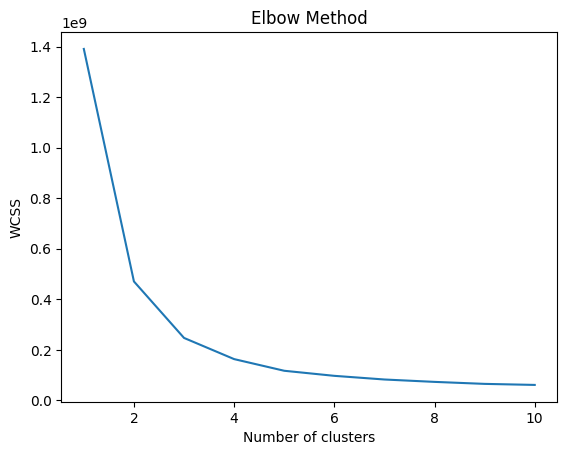

Enter the number of clusters: 5


C:\Users\Mantas Bertasius\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
user_movie_matrix = create_user_movie_matrix(user_watchlists, min_votes=50, min_ratings=10)
user_movie_matrix['num_ratings'] = (user_movie_matrix > 0).sum(axis=1)
user_movie_pop_user_item_clustered = add_user_clusters(user_movie_pop_user_item, user_movie_matrix, max_clusters=10)


In [29]:
user_movie_pop_user_item_clustered['user_cluster'].value_counts() # clusterized prety evenly in 5 clusters

1    455381
4    436453
3    396766
2    290219
0    197250
Name: user_cluster, dtype: int64

In [30]:
#one final feature to add is the previously explored genre similarity, we add that for each user-movie interaction in our training data




def create_user_profiles(movie_data, user_watchlists):
    genre_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
                     'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
                     'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
    
    user_movie_data = user_watchlists.merge(movie_data, left_on='imdb_id', right_on='tconst', how='inner') #merge both df's
    
    user_movie_data['penalty_factor'] = user_movie_data['rating']/ 10
    
    user_movie_data[genre_columns] = user_movie_data[genre_columns].multiply(user_movie_data['rating'] * user_movie_data['penalty_factor'], axis="index")
    
    user_movie_data['weighted_genres'] = user_movie_data[genre_columns].apply(lambda row: np.array(row), axis=1)
    user_profiles = user_movie_data.groupby('user_id')['weighted_genres'].apply(lambda x: np.vstack(x).mean(axis=0))
    
    return pd.DataFrame(user_profiles.tolist(), index=user_profiles.index)

def calculate_genre_similarity_score(movie_data, user_profiles):
    genre_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
                     'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
                     'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
    genre_matrix  = movie_data[genre_columns].values
    similarity_scores = cosine_similarity(user_profiles.values, genre_matrix)
    return similarity_scores

def add_genre_similarity_score(df, movie_data, user_profiles, genre_columns):
    merged_data = df.merge(movie_data[['tconst']], left_on='imdb_id', right_on='tconst', how='inner')
    user_movie_pairs = merged_data[['user_id', 'imdb_id']].values
    scores = []
    total_pairs = len(user_movie_pairs)
    progress_bar = tqdm(total=total_pairs, desc='Calculating genre similarity scores')
    for i, (user_id, imdb_id) in enumerate(user_movie_pairs):
        user_profile = user_profiles.loc[user_id]
        movie_genre = movie_data.loc[movie_data['tconst'] == imdb_id, genre_columns].values
        similarity_score = cosine_similarity([user_profile], movie_genre)[0][0]
        scores.append(similarity_score)
        progress_bar.update(1)
        if i % 1000 == 0:
            logging.info(f"Processed {i} out of {total_pairs} user-movie pairs")
    progress_bar.close()
    df['genre_similarity_score'] = scores
    return df

In [ ]:
genre_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
                     'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
                     'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
#DONT RUN THIS CELL, the genre similarity score calculation took over 20 hours
user_profiles = create_user_profiles(movie_data_with_popularity, user_watchlists)
user_movie_pop_user_item_genre = add_genre_similarity_score(user_movie_pop_user_item_clustered, movie_data_with_popularity, user_profiles, genre_columns)

In [31]:
#user_movie_pop_user_item_genre.to_csv('training_data.csv', index=False)
user_movie_pop_user_item_genre = pd.read_csv('training_data.csv') #big data file

So this is the data we will be training the model with, still some things to do like droping some non useful columns and normalizing the data, lets do some quick EDA 

In [32]:
user_movie_pop_user_item_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776069 entries, 0 to 1776068
Data columns (total 45 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   user_id                   object 
 1   imdb_id                   object 
 2   rating                    int64  
 3   tconst                    object 
 4   primaryTitle              object 
 5   isAdult                   int64  
 6   startYear                 float64
 7   runtimeMinutes            float64
 8   averageRating             float64
 9   numVotes                  float64
 10  primaryName               object 
 11  Action                    int64  
 12  Adult                     int64  
 13  Adventure                 int64  
 14  Animation                 int64  
 15  Biography                 int64  
 16  Comedy                    int64  
 17  Crime                     int64  
 18  Documentary               int64  
 19  Drama                     int64  
 20  Family                  

In [33]:
user_movie_pop_user_item_genre.describe()

,rating,isAdult,startYear,runtimeMinutes,averageRating,numVotes,Action,Adult,Adventure,Animation,...,Talk-Show,Thriller,War,Western,\N,popularity_score,collab_user_filter_score,collab_item_filter_score,user_cluster,genre_similarity_score
count,1.776069e+06,1.776069e+06,1.776069e+06,1.776069e+06,1.776069e+06,1.776069e+06,1.776069e+06,1.776069e+06,1.776069e+06,1.776069e+06,...,1.776069e+06,1.776069e+06,1.776069e+06,1.776069e+06,1.776069e+06,1.776069e+06,1.249598e+06,1.049894e+06,1.776069e+06,1.776069e+06
mean,6.594566e+00,6.593212e-04,1.997411e+03,1.089297e+02,6.659665e+00,1.793626e+05,2.696410e-01,6.812798e-04,2.094384e-01,4.653704e-02,...,1.689124e-06,1.774137e-01,2.338929e-02,1.582484e-02,2.314099e-04,7.200662e-01,4.611766e+00,5.221640e-01,2.236360e+00,5.167982e-01
std,2.065843e+00,2.566879e-02,2.210137e+01,4.486901e+01,1.092645e+00,2.945640e+05,4.437734e-01,2.609245e-02,4.069079e-01,2.106451e-01,...,1.299662e-03,3.820185e-01,1.511365e-01,1.247975e-01,1.521041e-02,1.690519e-01,2.340281e+00,1.190613e-01,1.360563e+00,1.810087e-01
min,0.000000e+00,0.000000e+00,1.894000e+03,3.000000e+00,1.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.020767e-01,0.000000e+00,2.184362e-01,0.000000e+00,0.000000e+00
25%,5.000000e+00,0.000000e+00,1.988000e+03,9.400000e+01,6.100000e+00,9.795000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.225501e-01,2.800000e+00,4.336335e-01,1.000000e+00,3.889510e-01
50%,7.000000e+00,0.000000e+00,2.005000e+03,1.050000e+02,6.800000e+00,6.312500e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.059593e-01,4.600000e+00,5.051673e-01,2.000000e+00,5.373652e-01
75%,8.000000e+00,0.000000e+00,2.014000e+03,1.200000e+02,7.400000e+00,2.185970e+05,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.974681e-01,6.500000e+00,5.940567e-01,3.000000e+00,6.560039e-01
max,1.000000e+01,1.000000e+00,2.023000e+03,5.142000e+04,9.700000e+00,2.733330e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.731550e+00,1.000000e+01,9.519197e-01,4.000000e+00,9.710083e-01


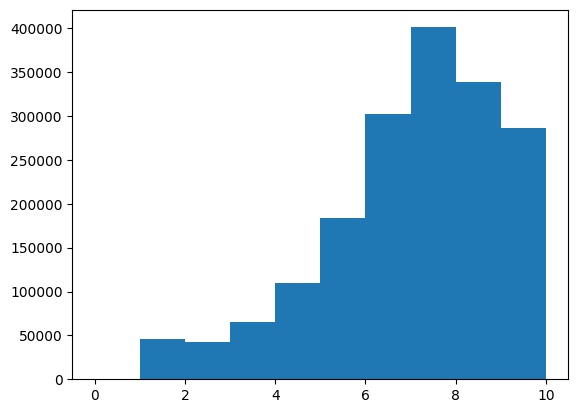

In [34]:
plt.hist(user_movie_pop_user_item_genre['rating'], bins=10)
plt.show()

C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\2524842938.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = user_movie_pop_user_item_genre.corr()


<AxesSubplot: >

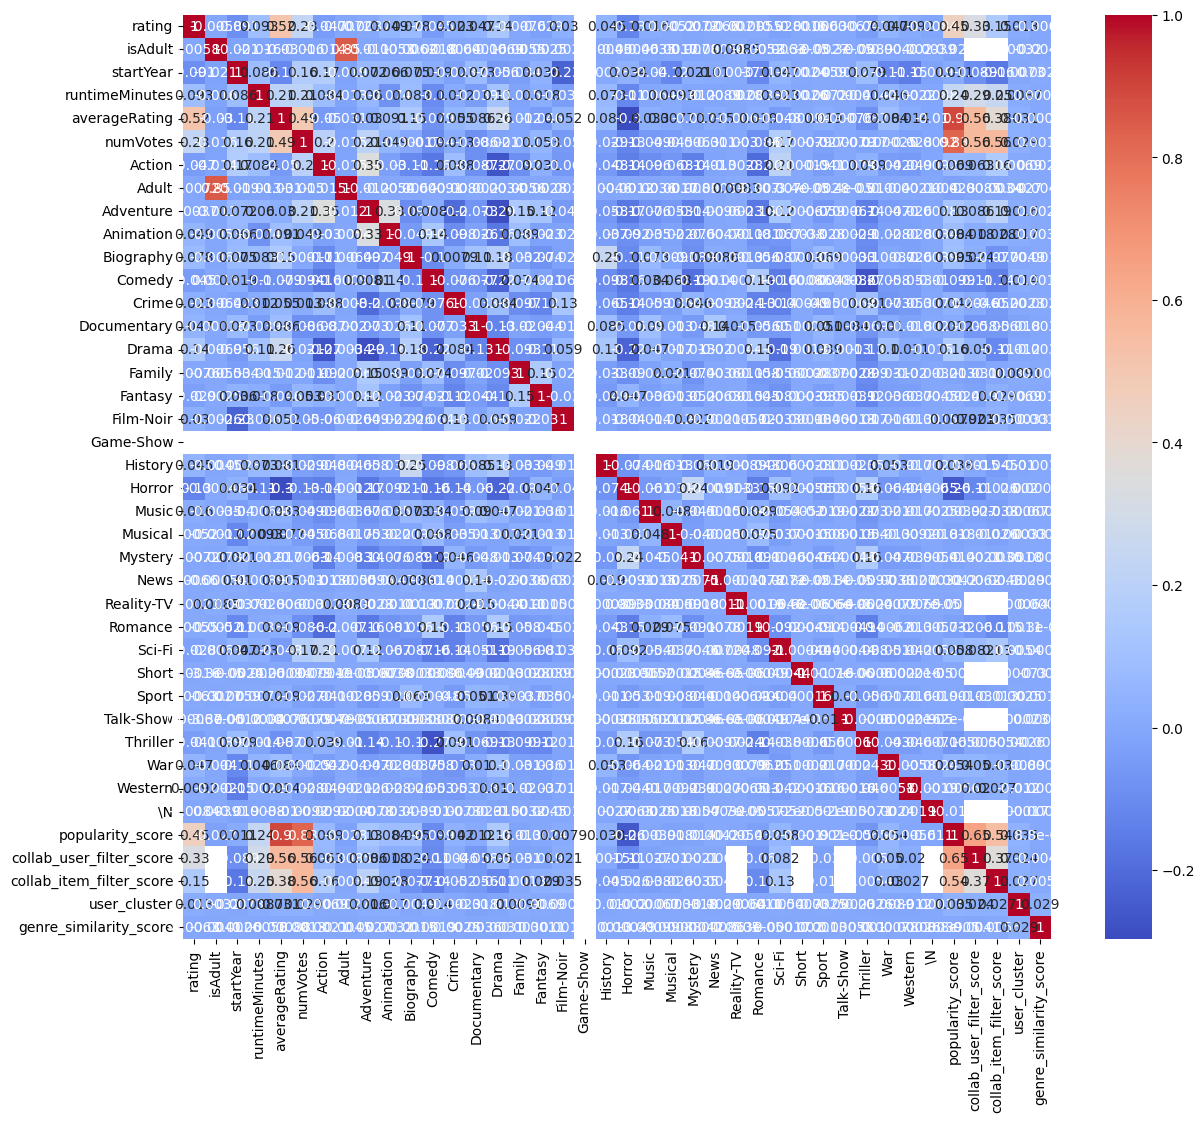

In [35]:
correlation = user_movie_pop_user_item_genre.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [36]:
user_movie_pop_user_item_genre.isnull().sum()

user_id                          0
imdb_id                          0
rating                           0
tconst                           0
primaryTitle                     0
isAdult                          0
startYear                        0
runtimeMinutes                   0
averageRating                    0
numVotes                         0
primaryName                      0
Action                           0
Adult                            0
Adventure                        0
Animation                        0
Biography                        0
Comedy                           0
Crime                            0
Documentary                      0
Drama                            0
Family                           0
Fantasy                          0
Film-Noir                        0
Game-Show                        0
History                          0
Horror                           0
Music                            0
Musical                          0
Mystery             

In [37]:
#we have some colab scores missing, lets try to fill them with user mean

user_movie_pop_user_item_genre['collab_user_filter_score'] = user_movie_pop_user_item_genre.groupby('user_id')['collab_user_filter_score'].transform(lambda x: x.fillna(x.mean()))
user_movie_pop_user_item_genre['collab_item_filter_score'] = user_movie_pop_user_item_genre.groupby('user_id')['collab_item_filter_score'].transform(lambda x: x.fillna(x.mean()))

# few n/a values remain for users that had no score at all so im dropping those
user_movie_pop_user_item_genre = user_movie_pop_user_item_genre.dropna(subset=['collab_user_filter_score', 'collab_item_filter_score'])


In [38]:
user_movie_pop_user_item_genre[user_movie_pop_user_item_genre['collab_item_filter_score'].isnull()]

,user_id,imdb_id,rating,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,...,Talk-Show,Thriller,War,Western,\N,popularity_score,collab_user_filter_score,collab_item_filter_score,user_cluster,genre_similarity_score


In [39]:
#user IDs and Movie ids dont have any information in them that would be useful to predict the score so we we will save those in a separate data structure

user_movie_pair_ids = user_movie_pop_user_item_genre[['user_id', 'imdb_id']].copy() 
prepared_training_data = user_movie_pop_user_item_genre.drop(columns=['user_id', 'imdb_id', 'tconst', 'primaryTitle', 'primaryName']) # drop unnecessary cols

current_year = datetime.datetime.now().year
prepared_training_data['years_since_release'] = current_year - prepared_training_data['startYear'] #absolute year is less informative than time since release
prepared_training_data = prepared_training_data.drop(columns=['startYear'])

In [40]:
prepared_training_data

,rating,isAdult,runtimeMinutes,averageRating,numVotes,Action,Adult,Adventure,Animation,Biography,...,Thriller,War,Western,\N,popularity_score,collab_user_filter_score,collab_item_filter_score,user_cluster,genre_similarity_score,years_since_release
0,8,0,83.0,8.0,250.0,0,0,0,0,0,...,0,0,0,0,0.801903,4.24842,0.548073,3,0.035008,11.0
1,7,0,139.0,7.9,435774.0,1,0,1,0,0,...,0,0,0,0,0.919528,6.60000,0.651005,3,0.689675,1.0
2,6,0,100.0,6.3,14740.0,0,0,0,0,0,...,0,0,0,0,0.636299,0.60000,0.548073,3,0.584016,1.0
3,6,0,84.0,6.7,111858.0,1,0,0,0,0,...,0,0,0,0,0.704243,4.40000,0.293664,3,0.584016,32.0
4,7,0,117.0,7.3,688979.0,1,0,0,0,0,...,0,0,0,0,0.933529,7.20000,0.724689,3,0.550145,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776064,9,0,101.0,7.6,59642.0,0,0,0,0,0,...,0,1,0,0,0.779224,4.20000,0.522673,0,0.240175,15.0
1776065,5,0,99.0,5.0,28898.0,1,0,0,0,0,...,0,0,0,0,0.510086,0.00000,0.522673,0,0.351084,24.0
1776066,9,0,80.0,5.5,3990.0,0,0,0,0,0,...,1,0,0,0,0.552858,3.03750,0.522673,0,0.036037,20.0
1776067,8,0,97.0,4.7,1614.0,1,0,0,0,0,...,0,0,0,0,0.472240,3.03750,0.522673,0,0.351084,15.0


In [80]:
# one_hot, scale and split the data
one_hot = pd.get_dummies(prepared_training_data, columns=['user_cluster'])


genre_columns = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 
                 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 
                 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
                 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western', '\\N']

feature_columns = ['years_since_release', 'averageRating', 'numVotes', 'isAdult', 'runtimeMinutes', 
                   'collab_user_filter_score', 'collab_item_filter_score'] #+ genre_columns

cluster_columns = [col for col in one_hot.columns if 'user_cluster' in col]

final_feature_columns = feature_columns + cluster_columns


final_features = one_hot[final_feature_columns]
target = prepared_training_data['rating']

X_train, X_test, y_train, y_test = train_test_split(final_features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


In [81]:
#neural net

gpus = tf.config.list_physical_devices('GPU')
np.random.seed(42)
tf.random.set_seed(42)

n_epochs = 50
batch_size = 1024
validation_split = 0.2
patience = 10
learning_rate = 0.003


def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

run = wandb.init(project="movie_recommendation_system",    name='final_model',    config={
    "batch_size": batch_size,
    "epochs": n_epochs,
    "learning_rate": learning_rate,
    "architecture": "fully connected ",
    "dataset": "scraped_imdb_data",
    'optimizer': 'adam',
    'patience': patience
})


model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, 
              loss='mean_squared_error', 
              metrics=['mean_absolute_error', root_mean_squared_error])


early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
checkpoint = ModelCheckpoint('final_model.h5', monitor='val_loss', save_best_only=True)


model.fit(X_train_scaled, y_train, 
          validation_split=validation_split, 
          epochs=n_epochs, 
          batch_size=batch_size, 
          callbacks=[early_stopping, checkpoint, WandbCallback()])

model.load_weights('final_model.h5')

test_loss, test_mae, test_rmse = model.evaluate(X_test_scaled, y_test)
wandb.log({"Test Loss": test_loss, "Test MAE": test_mae, "Test RMSE": test_rmse})

run.finish()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 64)                832       
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dense_28 (Dense)            (None, 16)                528       
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


C:\Users\Mantas Bertasius\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


1101/1110 [============================>.] - ETA: 0s - loss: 3.9102 - mean_absolute_error: 1.3865 - root_mean_squared_error: 1.8319

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 5s 4ms/step - loss: 3.9034 - mean_absolute_error: 1.3859 - root_mean_squared_error: 1.8312 - val_loss: 3.0539 - val_mean_absolute_error: 1.3268 - val_root_mean_squared_error: 1.7469
Epoch 2/50
1110/1110 [==============================] - 3s 2ms/step - loss: 3.1263 - mean_absolute_error: 1.3235 - root_mean_squared_error: 1.7530 - val_loss: 3.0630 - val_mean_absolute_error: 1.3162 - val_root_mean_squared_error: 1.7495
Epoch 3/50
1098/1110 [============================>.] - ETA: 0s - loss: 3.0450 - mean_absolute_error: 1.3202 - root_mean_squared_error: 1.7441

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 4s 3ms/step - loss: 3.0451 - mean_absolute_error: 1.3201 - root_mean_squared_error: 1.7441 - val_loss: 3.0476 - val_mean_absolute_error: 1.3189 - val_root_mean_squared_error: 1.7451
Epoch 4/50
1087/1110 [============================>.] - ETA: 0s - loss: 3.0387 - mean_absolute_error: 1.3194 - root_mean_squared_error: 1.7424

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 3.0397 - mean_absolute_error: 1.3196 - root_mean_squared_error: 1.7427 - val_loss: 3.0474 - val_mean_absolute_error: 1.3230 - val_root_mean_squared_error: 1.7451
Epoch 5/50
1110/1110 [==============================] - 2s 2ms/step - loss: 3.0357 - mean_absolute_error: 1.3188 - root_mean_squared_error: 1.7415 - val_loss: 3.0532 - val_mean_absolute_error: 1.3174 - val_root_mean_squared_error: 1.7467
Epoch 6/50
1093/1110 [============================>.] - ETA: 0s - loss: 3.0726 - mean_absolute_error: 1.3188 - root_mean_squared_error: 1.7456

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 3.0711 - mean_absolute_error: 1.3187 - root_mean_squared_error: 1.7452 - val_loss: 3.0380 - val_mean_absolute_error: 1.3230 - val_root_mean_squared_error: 1.7424
Epoch 7/50
1110/1110 [==============================] - 2s 2ms/step - loss: 3.0280 - mean_absolute_error: 1.3173 - root_mean_squared_error: 1.7395 - val_loss: 3.0403 - val_mean_absolute_error: 1.3144 - val_root_mean_squared_error: 1.7430
Epoch 8/50
1089/1110 [============================>.] - ETA: 0s - loss: 3.0229 - mean_absolute_error: 1.3164 - root_mean_squared_error: 1.7380

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 3.0239 - mean_absolute_error: 1.3165 - root_mean_squared_error: 1.7382 - val_loss: 3.0354 - val_mean_absolute_error: 1.3131 - val_root_mean_squared_error: 1.7416
Epoch 9/50
1090/1110 [============================>.] - ETA: 0s - loss: 3.0389 - mean_absolute_error: 1.3162 - root_mean_squared_error: 1.7404

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 3.0362 - mean_absolute_error: 1.3157 - root_mean_squared_error: 1.7397 - val_loss: 3.0249 - val_mean_absolute_error: 1.3178 - val_root_mean_squared_error: 1.7386
Epoch 10/50
1110/1110 [==============================] - 2s 2ms/step - loss: 3.0134 - mean_absolute_error: 1.3140 - root_mean_squared_error: 1.7352 - val_loss: 3.0336 - val_mean_absolute_error: 1.3093 - val_root_mean_squared_error: 1.7411
Epoch 11/50
1110/1110 [==============================] - 2s 2ms/step - loss: 3.0115 - mean_absolute_error: 1.3128 - root_mean_squared_error: 1.7345 - val_loss: 3.0360 - val_mean_absolute_error: 1.3257 - val_root_mean_squared_error: 1.7419
Epoch 12/50
1090/1110 [============================>.] - ETA: 0s - loss: 3.0005 - mean_absolute_error: 1.3107 - root_mean_squared_error: 1.7315

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 3.0010 - mean_absolute_error: 1.3108 - root_mean_squared_error: 1.7316 - val_loss: 3.0054 - val_mean_absolute_error: 1.3080 - val_root_mean_squared_error: 1.7330
Epoch 13/50
1110/1110 [==============================] - 2s 2ms/step - loss: 3.0076 - mean_absolute_error: 1.3101 - root_mean_squared_error: 1.7326 - val_loss: 3.0074 - val_mean_absolute_error: 1.3154 - val_root_mean_squared_error: 1.7336
Epoch 14/50
1110/1110 [==============================] - 2s 2ms/step - loss: 2.9930 - mean_absolute_error: 1.3086 - root_mean_squared_error: 1.7294 - val_loss: 3.0056 - val_mean_absolute_error: 1.3159 - val_root_mean_squared_error: 1.7331
Epoch 15/50
1110/1110 [==============================] - 2s 2ms/step - loss: 2.9875 - mean_absolute_error: 1.3070 - root_mean_squared_error: 1.7277 - val_loss: 3.0449 - val_mean_absolute_error: 1.3439 - val_root_mean_squared_error: 1.7445
Epoch 16/50
1084/1110 [============================>.] -

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9843 - mean_absolute_error: 1.3062 - root_mean_squared_error: 1.7268 - val_loss: 2.9927 - val_mean_absolute_error: 1.3143 - val_root_mean_squared_error: 1.7294
Epoch 17/50
1091/1110 [============================>.] - ETA: 0s - loss: 2.9801 - mean_absolute_error: 1.3033 - root_mean_squared_error: 1.7251

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9801 - mean_absolute_error: 1.3033 - root_mean_squared_error: 1.7251 - val_loss: 2.9792 - val_mean_absolute_error: 1.3007 - val_root_mean_squared_error: 1.7254
Epoch 18/50
1108/1110 [============================>.] - ETA: 0s - loss: 2.9874 - mean_absolute_error: 1.3017 - root_mean_squared_error: 1.7250

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9872 - mean_absolute_error: 1.3017 - root_mean_squared_error: 1.7249 - val_loss: 2.9774 - val_mean_absolute_error: 1.3061 - val_root_mean_squared_error: 1.7249
Epoch 19/50
1098/1110 [============================>.] - ETA: 0s - loss: 2.9622 - mean_absolute_error: 1.2998 - root_mean_squared_error: 1.7204

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9621 - mean_absolute_error: 1.2997 - root_mean_squared_error: 1.7204 - val_loss: 2.9752 - val_mean_absolute_error: 1.3002 - val_root_mean_squared_error: 1.7243
Epoch 20/50
1107/1110 [============================>.] - ETA: 0s - loss: 2.9588 - mean_absolute_error: 1.2991 - root_mean_squared_error: 1.7194

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9587 - mean_absolute_error: 1.2991 - root_mean_squared_error: 1.7194 - val_loss: 2.9733 - val_mean_absolute_error: 1.3020 - val_root_mean_squared_error: 1.7237
Epoch 21/50
1110/1110 [==============================] - 2s 2ms/step - loss: 2.9716 - mean_absolute_error: 1.2986 - root_mean_squared_error: 1.7212 - val_loss: 2.9800 - val_mean_absolute_error: 1.2953 - val_root_mean_squared_error: 1.7256
Epoch 22/50
1103/1110 [============================>.] - ETA: 0s - loss: 2.9529 - mean_absolute_error: 1.2975 - root_mean_squared_error: 1.7177

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9522 - mean_absolute_error: 1.2974 - root_mean_squared_error: 1.7175 - val_loss: 2.9658 - val_mean_absolute_error: 1.2948 - val_root_mean_squared_error: 1.7215
Epoch 23/50
1110/1110 [==============================] - 2s 2ms/step - loss: 2.9514 - mean_absolute_error: 1.2973 - root_mean_squared_error: 1.7173 - val_loss: 2.9827 - val_mean_absolute_error: 1.2936 - val_root_mean_squared_error: 1.7264
Epoch 24/50
1110/1110 [==============================] - 2s 2ms/step - loss: 2.9543 - mean_absolute_error: 1.2971 - root_mean_squared_error: 1.7179 - val_loss: 2.9694 - val_mean_absolute_error: 1.3085 - val_root_mean_squared_error: 1.7226
Epoch 25/50
1099/1110 [============================>.] - ETA: 0s - loss: 2.9509 - mean_absolute_error: 1.2964 - root_mean_squared_error: 1.7170

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9507 - mean_absolute_error: 1.2963 - root_mean_squared_error: 1.7169 - val_loss: 2.9550 - val_mean_absolute_error: 1.2949 - val_root_mean_squared_error: 1.7184
Epoch 26/50
1110/1110 [==============================] - 3s 3ms/step - loss: 2.9562 - mean_absolute_error: 1.2951 - root_mean_squared_error: 1.7170 - val_loss: 2.9582 - val_mean_absolute_error: 1.2940 - val_root_mean_squared_error: 1.7193
Epoch 27/50
1108/1110 [============================>.] - ETA: 0s - loss: 2.9403 - mean_absolute_error: 1.2944 - root_mean_squared_error: 1.7140

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 4s 3ms/step - loss: 2.9404 - mean_absolute_error: 1.2944 - root_mean_squared_error: 1.7140 - val_loss: 2.9525 - val_mean_absolute_error: 1.2965 - val_root_mean_squared_error: 1.7176
Epoch 28/50
1101/1110 [============================>.] - ETA: 0s - loss: 2.9373 - mean_absolute_error: 1.2939 - root_mean_squared_error: 1.7132

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 4s 3ms/step - loss: 2.9374 - mean_absolute_error: 1.2939 - root_mean_squared_error: 1.7132 - val_loss: 2.9520 - val_mean_absolute_error: 1.2971 - val_root_mean_squared_error: 1.7175
Epoch 29/50
1100/1110 [============================>.] - ETA: 0s - loss: 2.9351 - mean_absolute_error: 1.2931 - root_mean_squared_error: 1.7125

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9354 - mean_absolute_error: 1.2931 - root_mean_squared_error: 1.7126 - val_loss: 2.9512 - val_mean_absolute_error: 1.2929 - val_root_mean_squared_error: 1.7173
Epoch 30/50
1099/1110 [============================>.] - ETA: 0s - loss: 2.9326 - mean_absolute_error: 1.2926 - root_mean_squared_error: 1.7118

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9330 - mean_absolute_error: 1.2926 - root_mean_squared_error: 1.7119 - val_loss: 2.9442 - val_mean_absolute_error: 1.2949 - val_root_mean_squared_error: 1.7153
Epoch 31/50
1087/1110 [============================>.] - ETA: 0s - loss: 2.9323 - mean_absolute_error: 1.2925 - root_mean_squared_error: 1.7117

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9318 - mean_absolute_error: 1.2923 - root_mean_squared_error: 1.7115 - val_loss: 2.9439 - val_mean_absolute_error: 1.2912 - val_root_mean_squared_error: 1.7151
Epoch 32/50
1110/1110 [==============================] - 3s 2ms/step - loss: 2.9285 - mean_absolute_error: 1.2912 - root_mean_squared_error: 1.7106 - val_loss: 2.9533 - val_mean_absolute_error: 1.2970 - val_root_mean_squared_error: 1.7179
Epoch 33/50
1094/1110 [============================>.] - ETA: 0s - loss: 2.9264 - mean_absolute_error: 1.2907 - root_mean_squared_error: 1.7101

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9263 - mean_absolute_error: 1.2907 - root_mean_squared_error: 1.7100 - val_loss: 2.9381 - val_mean_absolute_error: 1.2958 - val_root_mean_squared_error: 1.7135
Epoch 34/50
1110/1110 [==============================] - 2s 2ms/step - loss: 2.9242 - mean_absolute_error: 1.2901 - root_mean_squared_error: 1.7094 - val_loss: 2.9501 - val_mean_absolute_error: 1.3068 - val_root_mean_squared_error: 1.7170
Epoch 35/50
1102/1110 [============================>.] - ETA: 0s - loss: 2.9211 - mean_absolute_error: 1.2891 - root_mean_squared_error: 1.7084

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9217 - mean_absolute_error: 1.2893 - root_mean_squared_error: 1.7086 - val_loss: 2.9361 - val_mean_absolute_error: 1.2942 - val_root_mean_squared_error: 1.7129
Epoch 36/50
1110/1110 [==============================] - 2s 2ms/step - loss: 2.9188 - mean_absolute_error: 1.2888 - root_mean_squared_error: 1.7078 - val_loss: 2.9493 - val_mean_absolute_error: 1.3039 - val_root_mean_squared_error: 1.7168
Epoch 37/50
1099/1110 [============================>.] - ETA: 0s - loss: 2.9173 - mean_absolute_error: 1.2882 - root_mean_squared_error: 1.7074

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9175 - mean_absolute_error: 1.2882 - root_mean_squared_error: 1.7074 - val_loss: 2.9319 - val_mean_absolute_error: 1.2893 - val_root_mean_squared_error: 1.7116
Epoch 38/50
1110/1110 [==============================] - 3s 2ms/step - loss: 2.9152 - mean_absolute_error: 1.2876 - root_mean_squared_error: 1.7067 - val_loss: 2.9354 - val_mean_absolute_error: 1.3027 - val_root_mean_squared_error: 1.7127
Epoch 39/50
1097/1110 [============================>.] - ETA: 0s - loss: 2.9327 - mean_absolute_error: 1.2876 - root_mean_squared_error: 1.7093

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9328 - mean_absolute_error: 1.2876 - root_mean_squared_error: 1.7093 - val_loss: 2.9312 - val_mean_absolute_error: 1.2914 - val_root_mean_squared_error: 1.7115
Epoch 40/50
1089/1110 [============================>.] - ETA: 0s - loss: 2.9112 - mean_absolute_error: 1.2867 - root_mean_squared_error: 1.7056

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 4s 3ms/step - loss: 2.9121 - mean_absolute_error: 1.2868 - root_mean_squared_error: 1.7058 - val_loss: 2.9304 - val_mean_absolute_error: 1.2871 - val_root_mean_squared_error: 1.7112
Epoch 41/50
1108/1110 [============================>.] - ETA: 0s - loss: 2.9096 - mean_absolute_error: 1.2864 - root_mean_squared_error: 1.7050

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9101 - mean_absolute_error: 1.2864 - root_mean_squared_error: 1.7051 - val_loss: 2.9237 - val_mean_absolute_error: 1.2847 - val_root_mean_squared_error: 1.7092
Epoch 42/50
1110/1110 [==============================] - 2s 2ms/step - loss: 2.9075 - mean_absolute_error: 1.2855 - root_mean_squared_error: 1.7045 - val_loss: 2.9412 - val_mean_absolute_error: 1.2846 - val_root_mean_squared_error: 1.7143
Epoch 43/50
1103/1110 [============================>.] - ETA: 0s - loss: 2.9061 - mean_absolute_error: 1.2851 - root_mean_squared_error: 1.7041

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9061 - mean_absolute_error: 1.2851 - root_mean_squared_error: 1.7041 - val_loss: 2.9230 - val_mean_absolute_error: 1.2942 - val_root_mean_squared_error: 1.7091
Epoch 44/50
1110/1110 [==============================] - 2s 2ms/step - loss: 2.9047 - mean_absolute_error: 1.2849 - root_mean_squared_error: 1.7036 - val_loss: 2.9240 - val_mean_absolute_error: 1.2950 - val_root_mean_squared_error: 1.7093
Epoch 45/50
1096/1110 [============================>.] - ETA: 0s - loss: 2.9016 - mean_absolute_error: 1.2841 - root_mean_squared_error: 1.7027

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9018 - mean_absolute_error: 1.2841 - root_mean_squared_error: 1.7028 - val_loss: 2.9208 - val_mean_absolute_error: 1.2933 - val_root_mean_squared_error: 1.7084
Epoch 46/50
1105/1110 [============================>.] - ETA: 0s - loss: 2.9014 - mean_absolute_error: 1.2839 - root_mean_squared_error: 1.7027

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 4s 3ms/step - loss: 2.9007 - mean_absolute_error: 1.2838 - root_mean_squared_error: 1.7024 - val_loss: 2.9188 - val_mean_absolute_error: 1.2858 - val_root_mean_squared_error: 1.7078
Epoch 47/50
1087/1110 [============================>.] - ETA: 0s - loss: 2.9015 - mean_absolute_error: 1.2838 - root_mean_squared_error: 1.7027

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9012 - mean_absolute_error: 1.2836 - root_mean_squared_error: 1.7026 - val_loss: 2.9157 - val_mean_absolute_error: 1.2919 - val_root_mean_squared_error: 1.7070
Epoch 48/50
1110/1110 [==============================] - ETA: 0s - loss: 2.9037 - mean_absolute_error: 1.2836 - root_mean_squared_error: 1.7031

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


1110/1110 [==============================] - 3s 3ms/step - loss: 2.9037 - mean_absolute_error: 1.2836 - root_mean_squared_error: 1.7031 - val_loss: 2.9146 - val_mean_absolute_error: 1.2883 - val_root_mean_squared_error: 1.7066
Epoch 49/50
1110/1110 [==============================] - 3s 2ms/step - loss: 2.9523 - mean_absolute_error: 1.2836 - root_mean_squared_error: 1.7076 - val_loss: 2.9169 - val_mean_absolute_error: 1.2844 - val_root_mean_squared_error: 1.7072
Epoch 50/50
1089/1110 [============================>.] - ETA: 0s - loss: 2.9065 - mean_absolute_error: 1.2827 - root_mean_squared_error: 1.7032

INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\Mantas Bertasius\PycharmProjects\movie_recommendation_system\wandb\run-20230522_205803-fnh6jjsj\files\model-best)... Done. 0.0s


11100/11100 [==============================] - 8s 763us/step - loss: 2.9034 - mean_absolute_error: 1.2843 - root_mean_squared_error: 1.6830


Test Loss,▁
Test MAE,▁
Test RMSE,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,█▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▇▇▇▆▇▅▅▅▅▄▄▄▄▃▄▄▃▃▃▃▂▃▂▃▃▂▂▂▂▂▁▂▁▁▁▁
val_mean_absolute_error,█▆▇▇▇▆▆▇█▅▆▆▆▄▅▄▃▃▂▅▃▃▃▂▂▃▃▅▄▂▄▂▁▁▃▃▁▂▂▁
val_root_mean_squared_error,██▇▇▇▇▇▆▇▅▅▅▅▄▄▄▄▃▄▄▃▃▃▃▂▃▂▃▃▂▂▂▂▂▁▂▁▁▁▁
Test Loss,2.9034


Lets unify all systems into one, then feed in their predictions to the neural net.

In [111]:
#function to accept user watchlist
def get_user_watchlist(file_path):
    watchlist = pd.read_csv(file_path)
    return watchlist


#simplest, popularity function
def calculate_popularity_score(df, alpha = 0.8, beta=1, gamma=0.002):
    df = df.copy()
    df['norm_numVotes'] = df['numVotes'] / df['numVotes'].max()
    df['norm_averageRating'] = df['averageRating'] / df['averageRating'].max()
    df['norm_startYear'] = (df['startYear'] - df['startYear'].min()) / (df['startYear'].max() - df['startYear'].min())
    df['popularity_score'] = alpha *df['norm_numVotes'] + beta * df['norm_averageRating'] + gamma * df['norm_startYear']
    df = df.drop(columns=['norm_numVotes', 'norm_averageRating', 'norm_startYear'])
    return df


def get_pop_movies_with_random(df, user_ratings_df, num_movies=5, top_percent = 0.01, min_votes= 10000, random_seed=None, genre=None):
    watched_movies = set(user_ratings_df['imdb_id'])
    df = df[~df['tconst'].isin(watched_movies)]
    
    if random_seed is not None:
        random.seed(random_seed)
    df = df[df['numVotes'] >= min_votes]
    if genre is not None:
        df = df[df[genre] == 1]
    top_n = int(df.shape[0] * top_percent)
    top_movies = df.head(top_n)
    num_movies = min(num_movies, top_movies.shape[0])
    selected_movies = top_movies.sample(num_movies, replace=False)
    columns=['primaryTitle', 'tconst', 'startYear', 'averageRating', 'numVotes', 'isAdult', 'runtimeMinutes']
    selected_movies = selected_movies[columns]
    return selected_movies


#item-based collaborative filtering
def create_user_movie_matrix(ratings_data, min_votes=50, min_ratings=10):
    popular_movies = ratings_data.groupby('imdb_id').filter(lambda x: len(x) >= min_votes)
    active_users = popular_movies.groupby('user_id').filter(lambda x: len(x) >= min_ratings)
    return active_users.pivot_table(index='user_id', columns='imdb_id', values='rating').fillna(0).astype('uint8')

def compute_movie_similarity(user_movie_matrix):
    user_movie_matrix_filled = user_movie_matrix.fillna(0)
    return cosine_similarity(user_movie_matrix_filled.T)

def get_top_similar_movies(movie_id, user_movie_matrix, similarity_matrix, n=10):
    movie_idx = user_movie_matrix.columns.get_loc(movie_id)
    similar_movie_indices = np.argsort(similarity_matrix[movie_idx])[::-1][1:n+1]
    similar_movie_ids = [user_movie_matrix.columns[i] for i in similar_movie_indices]
    return similar_movie_ids

def recommend_item_based(user_ratings_df, user_watchlists, movie_data, min_votes=10, num_rec=10):
    user_movie_matrix = create_user_movie_matrix(user_watchlists, min_votes)
    similarity_matrix = compute_movie_similarity(user_movie_matrix)
    watched_movies = set(user_ratings_df['imdb_id'])
    
    total_scores = defaultdict(float)
    
    for _, row in user_ratings_df.iterrows():
        movie_id = row['imdb_id']
        rating = row['rating']
        
        if movie_id not in user_movie_matrix.columns:
            continue
        
        similar_movies = get_top_similar_movies(movie_id, user_movie_matrix, similarity_matrix, num_rec)
        
        for similar_movie in similar_movies:
            if similar_movie in watched_movies:
                continue
            total_scores[similar_movie] += similarity_matrix[user_movie_matrix.columns.get_loc(movie_id), user_movie_matrix.columns.get_loc(similar_movie)] * rating
    
    recommended_movies = sorted(total_scores.items(), key=lambda x: x[1], reverse=True)[:num_rec]
    recommended_movie_ids = [movie[0] for movie in recommended_movies]
    
    return movie_data[movie_data['tconst'].isin(recommended_movie_ids)]


#User-based collaborative filtering

def compute_user_similarity(user_movie_matrix):
    user_movie_matrix_filled = user_movie_matrix.fillna(0)
    return cosine_similarity(user_movie_matrix_filled)

def generate_user_based_scores_1(user_movie_matrix, similarity_matrix, user_vector, n=10):
    for movie in user_movie_matrix.columns:
        if movie not in user_vector.index:
            user_vector[movie] = 0  # default rating

    user_vector = user_vector[user_movie_matrix.columns]

    user_similarity = cosine_similarity(user_vector.values.reshape(1, -1), user_movie_matrix)
    top_n_similar_users = user_similarity[0].argsort()[-n:][::-1]

    total_scores = defaultdict(float)

    for similar_user in top_n_similar_users:
        weight = user_similarity[0][similar_user]
        similar_user_ratings = user_movie_matrix.iloc[similar_user]

        for movie_id, movie_rating in similar_user_ratings.iteritems():
            if not np.isnan(movie_rating):
                total_scores[movie_id] += (movie_rating * weight)
    
    return total_scores

def recommend_user_based_collaborative(user_watchlist, user_watchlists, movies_df, num_rec=10):
    user_watchlists = user_watchlists.append(user_watchlist)
    watched_movies = set(user_watchlist['imdb_id'])

    user_movie_matrix = create_user_movie_matrix(user_watchlists)
    similarity_matrix = compute_user_similarity(user_movie_matrix)

    user_vector = user_watchlist.set_index('imdb_id')['rating']
    scores = generate_user_based_scores_1(user_movie_matrix, similarity_matrix, user_vector, num_rec)

    recommended_movies = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    recommended_movies = [movie for movie in recommended_movies if movie[0] not in watched_movies][:num_rec]
    recommended_movie_ids = [movie[0] for movie in recommended_movies]

    return movies_df[movies_df['tconst'].isin(recommended_movie_ids)][['primaryTitle', 'tconst', 'startYear', 'averageRating', 'numVotes', 'isAdult', 'runtimeMinutes']]



#genre based recommendations
def create_user_profiles(movie_data, user_watchlists):
    genre_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
                     'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
                     'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
    
    user_movie_data = user_watchlists.merge(movie_data, left_on='imdb_id', right_on='tconst', how='inner') #merge both df's
    
    user_movie_data['penalty_factor'] = user_movie_data['rating']/ 10
    
    user_movie_data[genre_columns] = user_movie_data[genre_columns].multiply(user_movie_data['rating'] * user_movie_data['penalty_factor'], axis="index")
    
    user_movie_data['weighted_genres'] = user_movie_data[genre_columns].apply(lambda row: np.array(row), axis=1)
    user_profiles = user_movie_data.groupby('user_id')['weighted_genres'].apply(lambda x: np.mean(np.vstack(x), axis=0))
    
    return user_profiles

def recommend_movies_based_on_genre(movie_data, user_watchlists, new_user_watchlist, num_pool=50, num_recommendations=10, alpha=0.7):
    movie_data = movie_data.copy()
    movie_data = movie_data[movie_data['numVotes'] >= 5000]
    movie_data_with_popularity = calculate_popularity_score(movie_data)
    combined_watchlist = pd.concat([user_watchlists, new_user_watchlist])
    user_id = new_user_watchlist.iloc[0, 0]
    
    user_profiles = create_user_profiles(movie_data_with_popularity, combined_watchlist)
    
    user_profile = user_profiles.loc[user_id]
    
    genre_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
                     'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
                     'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
    
    genre_matrix  = movie_data_with_popularity[genre_columns].values
    similarity_scores = cosine_similarity([user_profile], genre_matrix)
    
    popularity_scores = movie_data_with_popularity['popularity_score']
    weighted_similarity_scores = alpha * similarity_scores + (1-alpha) * popularity_scores.values.reshape(1, -1)
    
    sorted_movie_indices = np.argsort(weighted_similarity_scores[0])[::-1]
    user_seen_movies = set(new_user_watchlist['imdb_id'])
    
    recommended_movie_ids  = []
    for movie_idx in sorted_movie_indices:
        movie_id = movie_data_with_popularity.iloc[movie_idx]['tconst']
        if movie_id not in user_seen_movies:
            recommended_movie_ids.append(movie_id)
        if len(recommended_movie_ids) >= num_pool:
            break
    
    final_recommendations = random.sample(recommended_movie_ids, num_recommendations)
    
    columns=['primaryTitle', 'tconst', 'startYear', 'averageRating', 'numVotes', 'isAdult', 'runtimeMinutes']
    return movie_data_with_popularity.loc[movie_data_with_popularity['tconst'].isin(final_recommendations)][columns]



# add user_based and item_based scores to the recommendations
def compute_user_vector(user_watchlist, user_movie_matrix):
    user_vector = pd.Series(0, index=user_movie_matrix.columns)
    for _, row in user_watchlist.iterrows():
        movie_id = row['imdb_id']
        if movie_id in user_vector.index:
            user_vector[movie_id] = 1
    return user_vector

def get_top_similar_movies_item_based(movie_id, user_movie_matrix, similarity_matrix, n=10):
    if movie_id in user_movie_matrix.columns:
        movie_idx = user_movie_matrix.columns.get_loc(movie_id)
        similar_movie_indices = np.argsort(similarity_matrix[movie_idx])[::-1][1:n+1]
        similar_movie_ids = [user_movie_matrix.columns[i] for i in similar_movie_indices]
        similar_movie_scores = similarity_matrix[movie_idx, similar_movie_indices]
        return dict(zip(similar_movie_ids, similar_movie_scores))
    else:
        return {}


    
def get_top_similar_users(user_id, user_movie_matrix, similarity_matrix, n=10):
    if user_id in user_movie_matrix.index:
        user_idx = user_movie_matrix.index.get_loc(user_id)
        similar_user_indices = np.argsort(similarity_matrix[user_idx])[::-1][1:n+1]
        similar_user_ids = [user_movie_matrix.index[i] for i in similar_user_indices]
        return similar_user_ids
    else:
        return []


def generate_item_based_scores(user_vector, user_movie_matrix, similarity_matrix, n=10):
    scores = {}
    for movie_id in user_vector[user_vector > 0].index:
        movie_scores = get_top_similar_movies_item_based(movie_id, user_movie_matrix, similarity_matrix, n)
        scores.update(movie_scores)
    return scores

def generate_user_based_scores(user_vector, user_movie_matrix, similarity_matrix, n=10):
    similarity_scores = cosine_similarity(user_vector.values.reshape(1, -1), user_movie_matrix)[0]
    top_similar_users = np.argsort(similarity_scores)[::-1][:n]
    scores = user_movie_matrix.iloc[top_similar_users].mean()
    return scores


#clusterize user
def get_user_cluster(user_vector, user_movie_matrix, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(user_movie_matrix)
    user_cluster = kmeans.predict(user_vector.values.reshape(1, -1))[0]
    return user_cluster



# main recommendation function
def recommend_movies(user_watchlist_path, user_watchlists_path, movie_database_path, num_recommendations=10, random_seed=None):
    columns = ['primaryTitle', 'tconst', 'startYear', 'averageRating', 'numVotes', 'isAdult', 'runtimeMinutes']
    movies_df = pd.read_csv(movie_database_path)
    user_watchlists = pd.read_csv(user_watchlists_path)
    user_watchlist = pd.read_csv(user_watchlist_path)

    user_watchlists = user_watchlists.append(user_watchlist)
    movies_df = movies_df[movies_df['numVotes'] >= 5000]  # filtering out movies with less than 5000 votes

    movies_df = calculate_popularity_score(movies_df)
    
    # popular movies
    popular_movies = get_pop_movies_with_random(movies_df, user_watchlist, num_movies=num_recommendations, random_seed=random_seed)
    print('step 1 done')
    # item based colaborative filtering
    collaborative_movies = recommend_item_based(user_watchlist, user_watchlists, movies_df, num_rec=num_recommendations)
    collaborative_movies = collaborative_movies[columns]
    print('step 2 done')
    # user based colaborative filtering
    user_movie_matrix = create_user_movie_matrix(user_watchlists)
    user_based_movies = recommend_user_based_collaborative(user_watchlist, user_watchlists, movies_df, num_rec=num_recommendations)
    user_based_movies = user_based_movies[columns]
    print('step 3 done')
    # genre based recommendations
    genre_based_movies = recommend_movies_based_on_genre(movies_df, user_watchlists, user_watchlist, num_recommendations=num_recommendations)
    genre_based_movies = genre_based_movies[columns]
    print('step 4 done')
    # combining all recommendations
    recommended_movies = pd.concat([popular_movies, collaborative_movies, user_based_movies, genre_based_movies])
    
    user_vector = compute_user_vector(user_watchlist, user_movie_matrix)

    # compute the similarity matrices
    item_similarity_matrix = compute_movie_similarity(user_movie_matrix)
    user_similarity_matrix = compute_user_similarity(user_movie_matrix)
    
    # compute the collaborative filtering scores
    item_based_scores = generate_item_based_scores(user_vector, user_movie_matrix, item_similarity_matrix)
    user_based_scores = generate_user_based_scores(user_vector, user_movie_matrix, user_similarity_matrix)
    print('step 5 done')
    # add the scores to the recommended_movies DataFrame
    recommended_movies['collab_item_filter_score'] = recommended_movies['tconst'].apply(lambda x: item_based_scores.get(x, 0))
    recommended_movies['collab_user_filter_score'] = recommended_movies['tconst'].apply(lambda x: user_based_scores.get(x, 0))
    
    # cluster user
    user_cluster = get_user_cluster(user_vector, user_movie_matrix, num_clusters=5) # clusterizing using 5 clusters
    recommended_movies['user_cluster'] = user_cluster
    
    #change release year to year since release
    current_year = datetime.datetime.now().year
    recommended_movies['years_since_release'] = current_year - recommended_movies['startYear']

    return recommended_movies


# inference step
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 


def inference(recommendations, scaler_path, model_path):
    scaler = pickle.load(open(scaler_path, 'rb'))
    model = load_model(model_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
    
    movie_ids = recommendations['tconst'].values # save ids for later

    encoder = OneHotEncoder(sparse=False)
    user_cluster_encoded = encoder.fit_transform(recommendations[['user_cluster']])
    user_cluster_df = pd.DataFrame(user_cluster_encoded, columns=[f'user_cluster_{i}' for i in range(user_cluster_encoded.shape[1])])
    
    recommendations.reset_index(drop=True, inplace=True)
    user_cluster_df.reset_index(drop=True, inplace=True)
    
    recommendations = pd.concat([recommendations, user_cluster_df], axis=1)

    user_cluster_cols = [col for col in recommendations.columns if 'user_cluster_' in col]

    missing_cluster_cols = set(['user_cluster_0', 'user_cluster_1', 'user_cluster_2', 
                            'user_cluster_3', 'user_cluster_4']) - set(user_cluster_cols)

    for col in missing_cluster_cols:
        recommendations[col] = 0

    required_cols = ['years_since_release', 'averageRating', 'numVotes', 
                 'isAdult', 'runtimeMinutes', 'collab_user_filter_score', 
                 'collab_item_filter_score', 'user_cluster_0', 'user_cluster_1', 
                 'user_cluster_2', 'user_cluster_3', 'user_cluster_4']
    inference_df = recommendations[required_cols]

    scaled_features = scaler.transform(inference_df)
    predictions = model.predict(scaled_features)
    results = list(zip(movie_ids, predictions.flatten()))
    results.sort(key=lambda x: x[1], reverse=True)

    return results


def movie_recommendation_pipeline(user_watchlist_path, user_watchlists_path, movie_database_path, 
                                  scaler_path, model_path, num_recommendations=10, random_seed=None):
    
    recommendations = recommend_movies(user_watchlist_path, user_watchlists_path, 
                                       movie_database_path, num_recommendations, random_seed)
    print('Recommendation step complete, inference step begins')
    results = inference(recommendations, scaler_path, model_path)

    return results



def movie_recommendation_pipeline(user_watchlist_path, user_watchlists_path, movie_database_path, 
                                  scaler_path, model_path, num_recommendations=10, random_seed=None):
    
    recommendations = recommend_movies(user_watchlist_path, user_watchlists_path, 
                                       movie_database_path, num_recommendations, random_seed)
    print('Recommendation step complete, inference step begins')
    predictions = inference(recommendations, scaler_path, model_path)
    
    results_df = recommendations.copy()
    results_df['predicted_rating'] = [prediction[1] for prediction in predictions]
    results_df['imdb_id'] = [prediction[0] for prediction in predictions]
    
    required_cols = ['primaryTitle', 'imdb_id', 'years_since_release', 'averageRating', 'numVotes', 
                     'isAdult', 'runtimeMinutes', 'collab_user_filter_score', 
                     'collab_item_filter_score', 'predicted_rating']
    
    results_df = results_df[required_cols]
    results_df.sort_values(by='predicted_rating', ascending=False, inplace=True)

    return results_df

In [100]:
recommend_movies('data/user_ratings_data/test_ratings.csv', 'data/user_ratings_data/user_watchlists.csv', 'data/film_data/prepared_film_data.csv', num_recommendations=10, random_seed=None)

C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\4286709427.py:241: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_watchlists = user_watchlists.append(user_watchlist)


step 1 done
step 2 done


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\4286709427.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_watchlists = user_watchlists.append(user_watchlist)
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\4286709427.py:101: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, movie_rating in similar_user_ratings.iteritems():


step 3 done
step 4 done
step 5 done


C:\Users\Mantas Bertasius\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Mantas Bertasius\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


,primaryTitle,tconst,startYear,averageRating,numVotes,isAdult,runtimeMinutes,item_based_score,user_based_score,user_cluster,years_since_release
18878,Interiors,tt0077742,1978.0,7.3,20248.0,0,92.0,0.000000,0.0,3,45.0
16947,Au hasard Balthazar,tt0060138,1966.0,7.8,21462.0,0,95.0,0.573580,0.0,3,57.0
19429,Mephisto,tt0082736,1981.0,7.7,11114.0,0,146.0,0.000000,0.0,3,42.0
19037,The Marriage of Maria Braun,tt0079095,1979.0,7.7,14272.0,0,120.0,0.000000,0.0,3,44.0
12016,Once Upon a Time in China II,tt0105839,1992.0,7.3,10224.0,0,113.0,0.000000,0.0,3,31.0
16413,Days of Wine and Roses,tt0055895,1962.0,7.8,13410.0,0,117.0,0.000000,0.0,3,61.0
16628,Winter Light,tt0057358,1963.0,8.0,25873.0,0,81.0,0.540227,0.0,3,60.0
17831,Two-Lane Blacktop,tt0067893,1971.0,7.2,12894.0,0,102.0,0.000000,0.0,3,52.0
15750,Throne of Blood,tt0050613,1957.0,8.1,53651.0,0,110.0,0.593165,0.0,3,66.0
19458,Ragtime,tt0082970,1981.0,7.3,10105.0,0,155.0,0.000000,0.0,3,42.0


In [112]:
results = movie_recommendation_pipeline('data/user_ratings_data/test_ratings.csv', 'data/user_ratings_data/user_watchlists.csv', 'data/film_data/prepared_film_data.csv', 
                                        'scaler.pkl', 'final_model.h5')
for movie_id, predicted_rating in results:
    print(f"Movie ID: {movie_id}, Predicted Rating: {predicted_rating}")

C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\1507886429.py:241: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_watchlists = user_watchlists.append(user_watchlist)


step 1 done
step 2 done


C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\1507886429.py:108: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_watchlists = user_watchlists.append(user_watchlist)
C:\Users\Mantas Bertasius\AppData\Local\Temp\ipykernel_4148\1507886429.py:101: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for movie_id, movie_rating in similar_user_ratings.iteritems():


step 3 done
step 4 done
step 5 done


C:\Users\Mantas Bertasius\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Mantas Bertasius\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Recommendation step complete, inference step begins


C:\Users\Mantas Bertasius\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


2/2 [==============================] - 0s 5ms/step


ValueError: too many values to unpack (expected 2)